In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Previous notebook (10-31-2017) use CA1, iCA1 and CA3 when available to detect ripples and decode replay events, but our decoding percentage wasn't very good.

This analysis is now just considering each brain area separately, which is more in line (I think) with how Loren's lab does it.

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='poster', font_scale=0.9,
            rc={'xtick.major.size': 3,
                'ytick.major.size': 3,
                'xtick.major.width': 1,
                'ytick.major.width': 1,
                'xtick.major.pad': 3.5,
                'ytick.major.pad': 3.5,
                'axes.linewidth': 1,
                'lines.linewidth': 2,
               })

from src.parameters import PROCESSED_DATA_DIR, ANIMALS, COLORS
from loren_frank_data_processing import make_epochs_dataframe, read_analysis_files

In [3]:
epoch_info = make_epochs_dataframe(ANIMALS)
epoch_info = epoch_info.loc[
    (epoch_info.type == 'run') &
    (epoch_info.environment != 'lin')]
epoch_keys = epoch_info.index

In [4]:
def preprocess(ds):
    return ds.drop(['start_time', 'end_time', 'ripple_duration', 'animal', 'day', 'epoch'])

replay_info = (read_analysis_files(
    PROCESSED_DATA_DIR, epoch_keys, group='/replay_info',
    preprocess=preprocess)
    .reset_index('recording_session')
     .to_dataframe()
     .dropna()
     .set_index(['animal', 'day', 'epoch', 'ripple_number']))

In [5]:
replay_info.head(5)

predicted_state  predicted_state_probability  \
animal day epoch ripple_number                                                  
Cor    1   2     1.0            Outbound-Forward                     0.917986   
           4     1.0            Outbound-Reverse                     0.579890   
       2   2     1.0             Inbound-Forward                     0.521650   
           4     1.0             Inbound-Reverse                     0.994762   
       3   2     1.0             Inbound-Reverse                     0.357275   

                               replay_task replay_order session_time  \
animal day epoch ripple_number                                         
Cor    1   2     1.0              Outbound      Forward        early   
           4     1.0              Outbound      Reverse        early   
       2   2     1.0               Inbound      Forward        early   
           4     1.0               Inbound      Reverse        early   
       3   2     1.0               Inbound      Reverse        early   

                                number_of_unique_spiking  number_of_spikes  \
animal day epoch ripple_number                                               
Cor    1   2     1.0                                10.0              21.0   
           4     1.0                                11.0             292.0   
       2   2     1.0                                 5.0              17.0   
           4     1.0                                 9.0              42.0   
       3   2     1.0                                 2.0               2.0   

                               trajectory_direction trajectory_turn  \
animal day epoch ripple_number                                        
Cor    1   2     1.0                       Outbound            Left   
           4     1.0                       Outbound            Left   
       2   2     1.0                        Inbound           Right   
           4     1.0                        Inbound           Right   
       3   2     1.0                       Outbound            Left   

                                trial_number  linear_distance  x_position  \
animal day epoch ripple_number                                              
Cor    1   2     1.0                     2.0        24.712378  279.300000   
           4     1.0                     1.0         0.000000  280.440000   
       2   2     1.0                     1.0         0.000000  279.300000   
           4     1.0                     1.0         0.000000  280.292346   
       3   2     1.0                     1.0         0.000000  281.309199   

                                y_position  head_direction     speed  \
animal day epoch ripple_number                                         
Cor    1   2     1.0                169.86       -1.965587  2.704379   
           4     1.0                196.08        1.487655  0.208113   
       2   2     1.0                198.36        1.570796  1.452093   
           4     1.0                196.08        1.091628  3.969273   
       3   2     1.0                200.64        1.354471  0.548286   

                                linear_position replay_motion  
animal day epoch ripple_number                                 
Cor    1   2     1.0                  24.712378       Towards  
           4     1.0                   0.000000       Towards  
       2   2     1.0                   0.000000       Towards  
           4     1.0                   0.000000       Towards  
       3   2     1.0                   0.000000       Towards

In [6]:
THRESHOLD = 0.9

replay_info['session_time'] = pd.Categorical(
    replay_info.session_time, ordered=True,
    categories=['early', 'middle', 'late'])

replay_info['replay_task'] = replay_info.replay_task.where(
    replay_info.predicted_state_probability >= THRESHOLD, 'Unclassified')
replay_info['replay_order'] = replay_info.replay_order.where(
    replay_info.predicted_state_probability >= THRESHOLD, 'Unclassified')
replay_info['replay_motion'] = replay_info.replay_motion.where(
    replay_info.predicted_state_probability >= THRESHOLD, 'Unclassified')
replay_info['predicted_state'] = replay_info.predicted_state.where(
    replay_info.predicted_state_probability >= THRESHOLD, 'Unclassified')

## Over animals

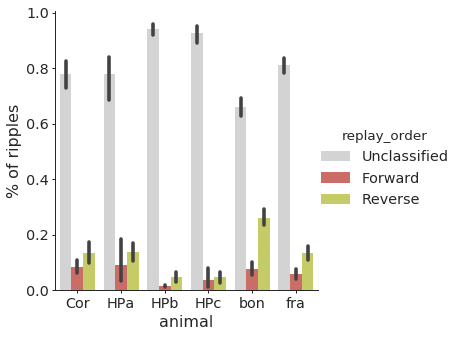

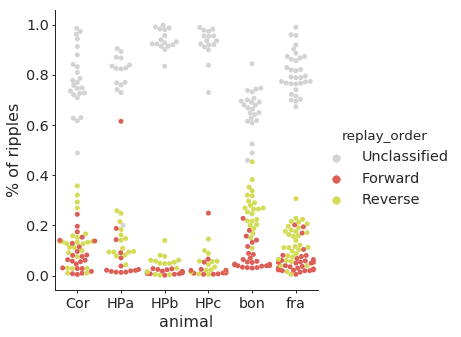

In [7]:
covariate = 'replay_order'

replay_percentage = (replay_info
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('% of ripples')
 .reset_index())

sns.factorplot(data=replay_percentage, x='animal', y='% of ripples', hue=covariate,
               palette=COLORS, size=5, kind='bar');
sns.factorplot(data=replay_percentage, x='animal', y='% of ripples', hue=covariate,
               kind='swarm', palette=COLORS, size=5);

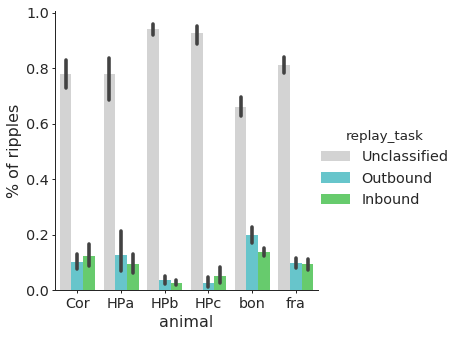

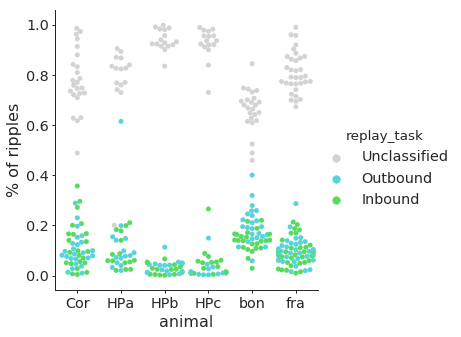

In [8]:
covariate = 'replay_task'

replay_percentage = (replay_info
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('% of ripples')
 .reset_index())

sns.factorplot(data=replay_percentage, x='animal', y='% of ripples', hue=covariate,
               palette=COLORS, size=5, kind='bar');
sns.factorplot(data=replay_percentage, x='animal', y='% of ripples', hue=covariate,
               kind='swarm', palette=COLORS, size=5);

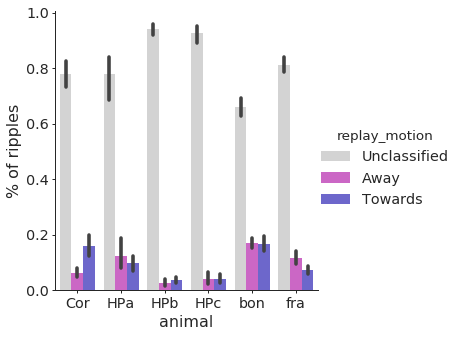

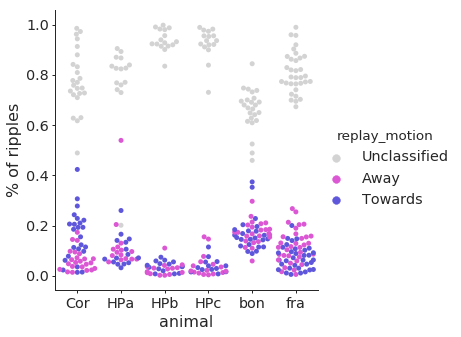

In [9]:
covariate = 'replay_motion'

replay_percentage = (replay_info
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('% of ripples')
 .reset_index())

sns.factorplot(data=replay_percentage, x='animal', y='% of ripples', hue=covariate,
               palette=COLORS, size=5, kind='bar');
sns.factorplot(data=replay_percentage, x='animal', y='% of ripples', hue=covariate,
               kind='swarm', palette=COLORS, size=5);

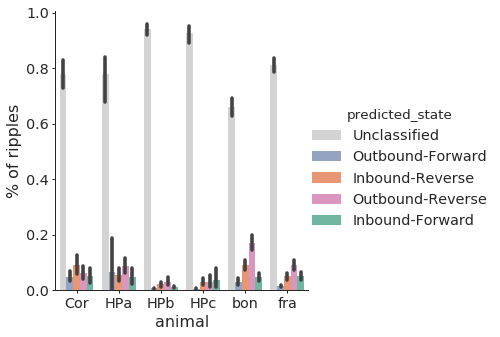

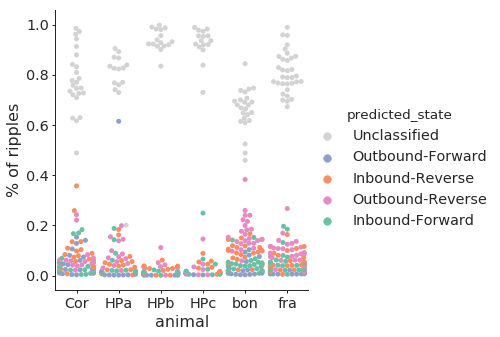

In [10]:
covariate = 'predicted_state'

replay_percentage = (replay_info
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('% of ripples')
 .reset_index())

sns.factorplot(data=replay_percentage, x='animal', y='% of ripples', hue=covariate,
               palette=COLORS, size=5, kind='bar');
sns.factorplot(data=replay_percentage, x='animal', y='% of ripples', hue=covariate,
               kind='swarm', palette=COLORS, size=5);

## Over Epochs

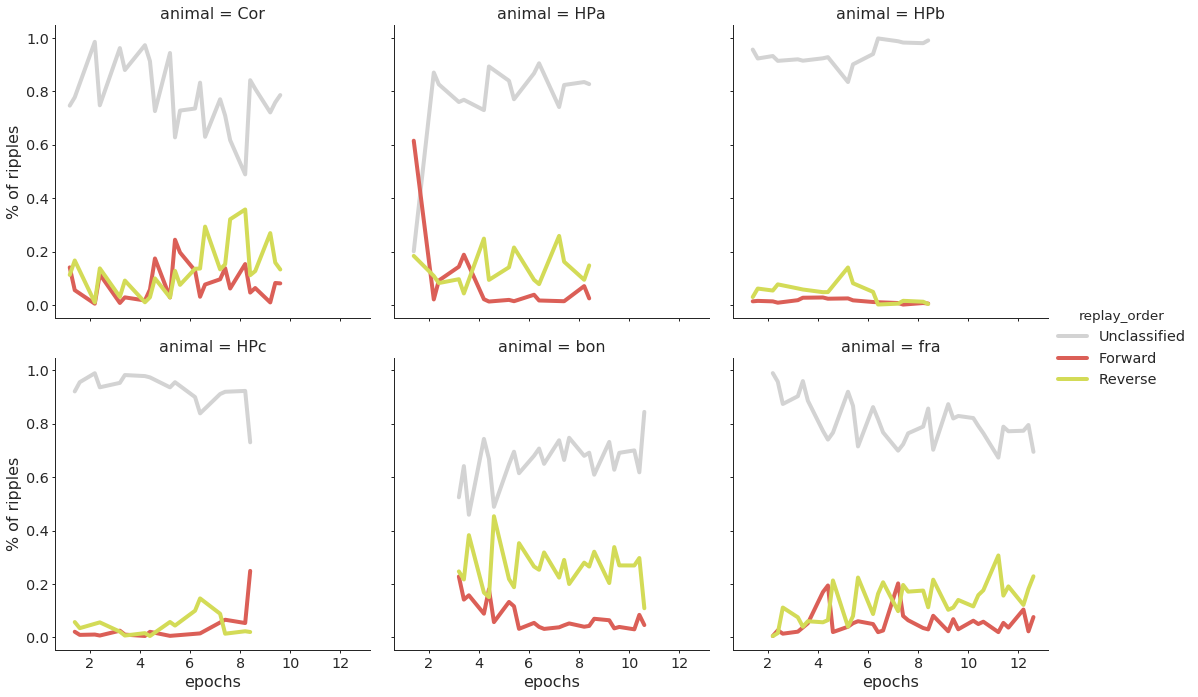

In [11]:
covariate = 'replay_order'
replay_percentage = (replay_info
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('% of ripples')
 .reset_index()
 .assign(epochs=lambda df: df.day + df.epoch * 0.1))


g = sns.FacetGrid(data=replay_percentage, col='animal', col_wrap=3,
                  hue=covariate, palette=COLORS, size=5)

g = g.map(plt.plot, 'epochs', '% of ripples', linewidth=4)
g.add_legend();

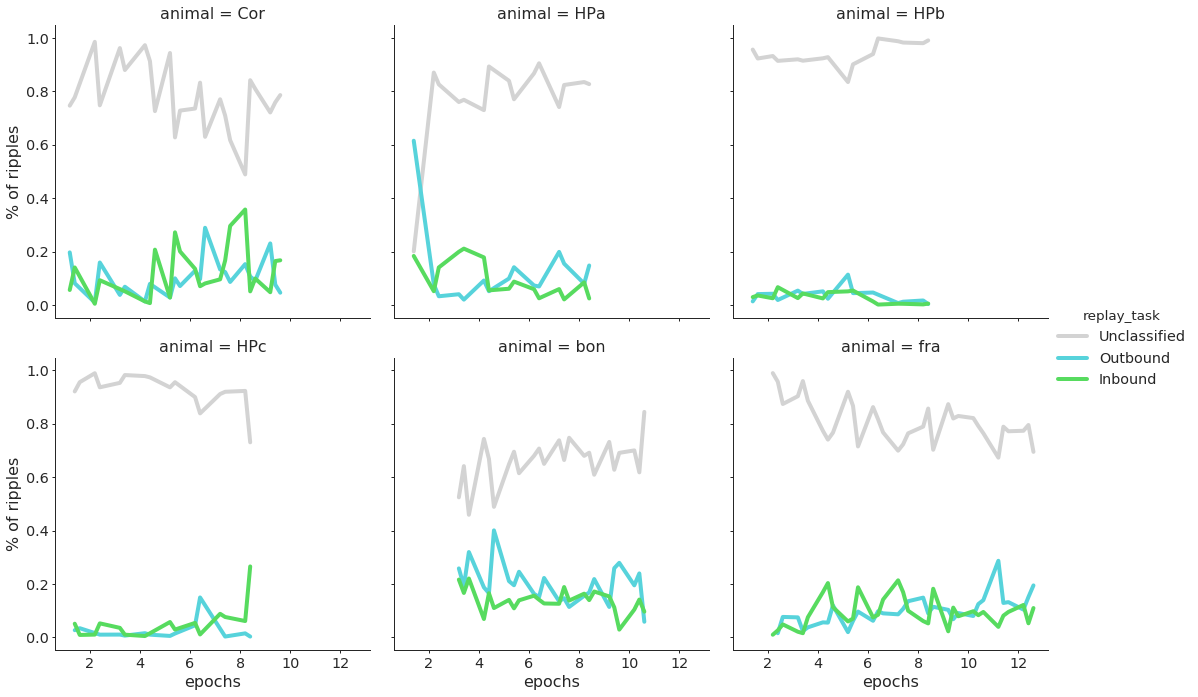

In [12]:
covariate = 'replay_task'

replay_percentage = (replay_info
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('% of ripples')
  .reset_index()
 .assign(epochs=lambda df: df.day + df.epoch * 0.1))


g = sns.FacetGrid(data=replay_percentage, col='animal', col_wrap=3,
                  hue=covariate, palette=COLORS, size=5)
g = g.map(plt.plot, 'epochs', '% of ripples', linewidth=4)
g.add_legend();

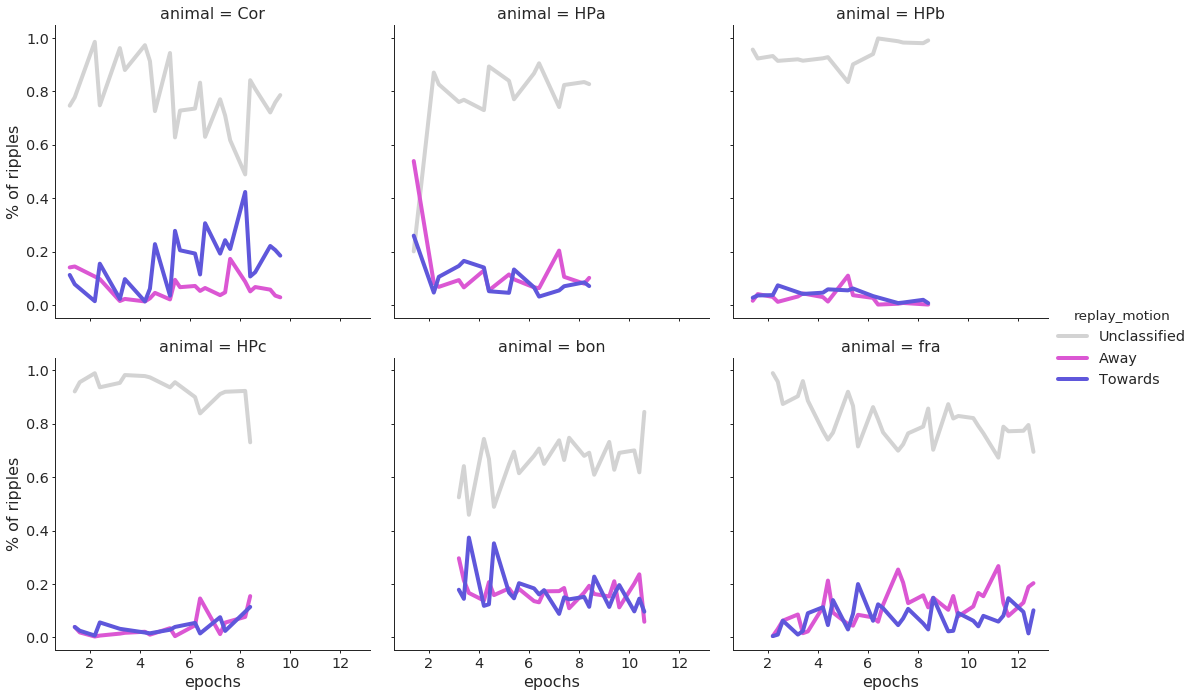

In [13]:
covariate = 'replay_motion'
replay_percentage = (replay_info
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('% of ripples')
  .reset_index()
 .assign(epochs=lambda df: df.day + df.epoch * 0.1))


g = sns.FacetGrid(data=replay_percentage, col='animal', col_wrap=3,
                  hue=covariate, palette=COLORS, size=5)
g = g.map(plt.plot, 'epochs', '% of ripples', linewidth=4)
g.add_legend();

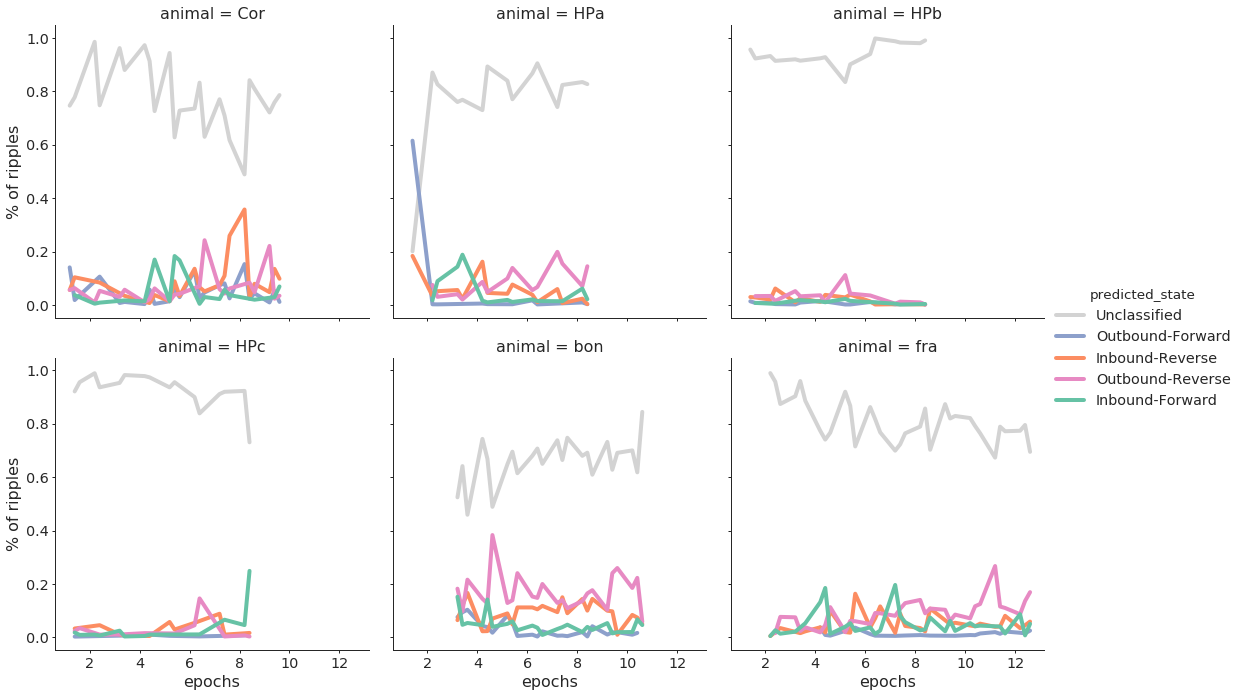

In [14]:
covariate = 'predicted_state'
replay_percentage = (replay_info
 .groupby(['animal', 'day', 'epoch'])[covariate].value_counts(normalize=True)
 .rename('% of ripples')
  .reset_index()
 .assign(epochs=lambda df: df.day + df.epoch * 0.1))


g = sns.FacetGrid(data=replay_percentage, col='animal', col_wrap=3,
                  hue=covariate, palette=COLORS, size=5)
g = g.map(plt.plot, 'epochs', '% of ripples', linewidth=4)
g.add_legend();

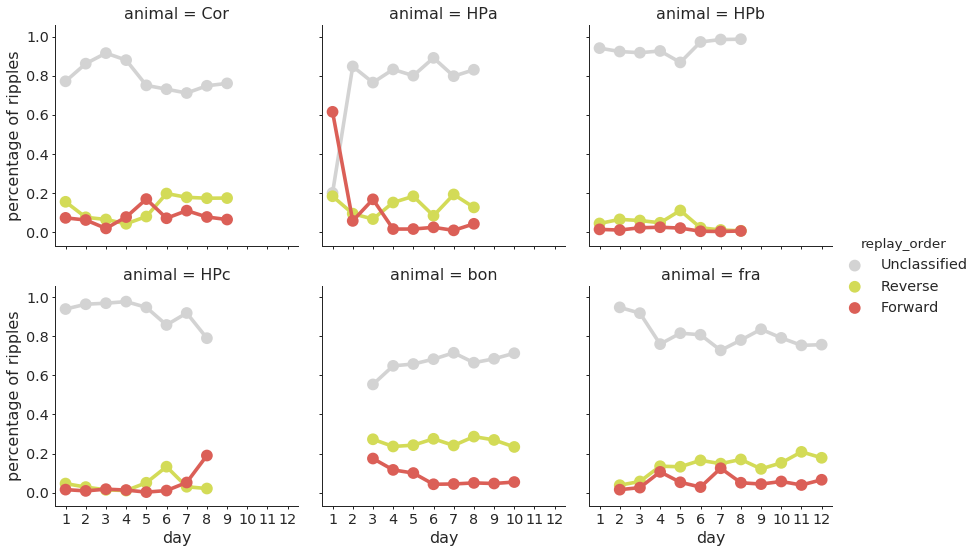

In [15]:
covariate = 'replay_order'
percentage_of_ripples = (replay_info.reset_index()
 .groupby(['animal', 'day'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='day', y='percentage of ripples',
               hue=covariate, col='animal', col_wrap=3, palette=COLORS);

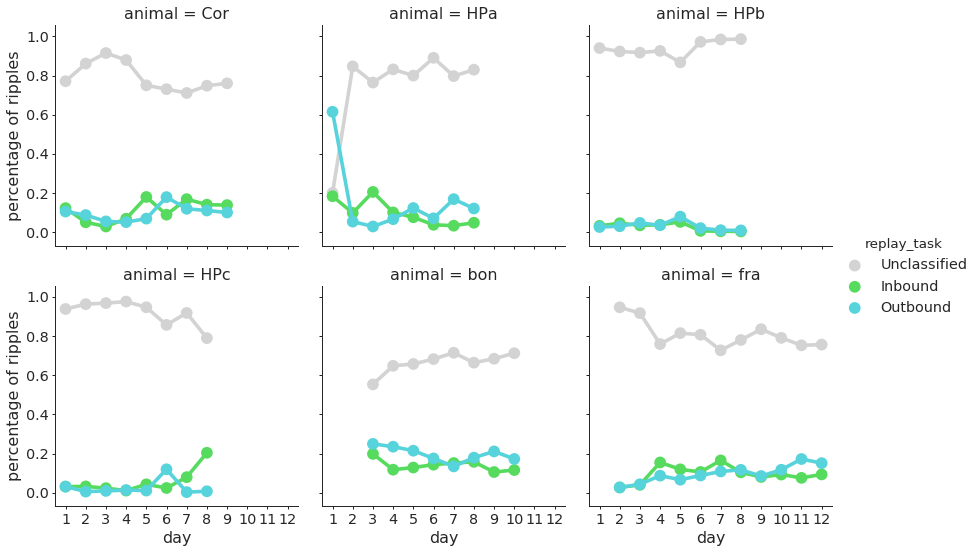

In [16]:
covariate = 'replay_task'
percentage_of_ripples = (replay_info.reset_index()
 .groupby(['animal', 'day'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='day', y='percentage of ripples',
               hue=covariate, col='animal', col_wrap=3, palette=COLORS);

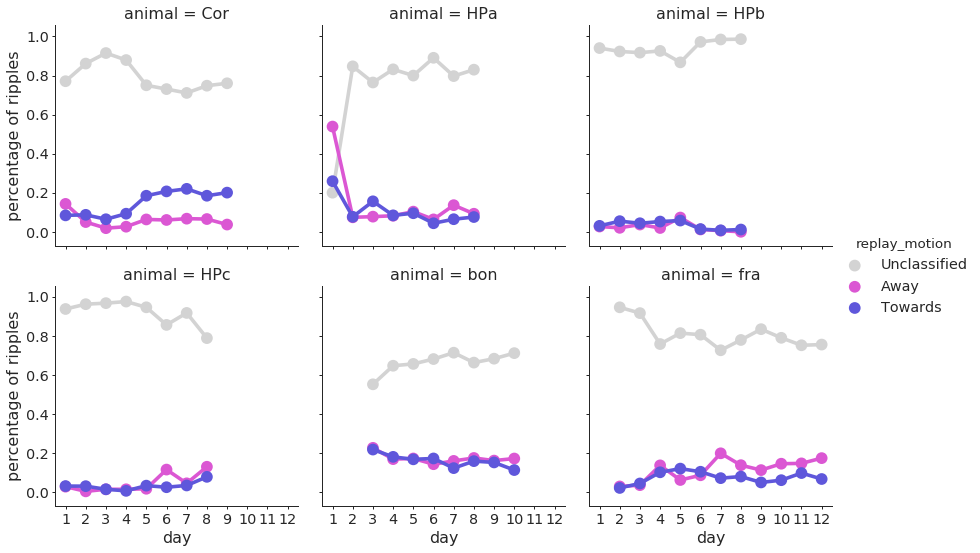

In [17]:
covariate = 'replay_motion'
percentage_of_ripples = (replay_info.reset_index()
 .groupby(['animal', 'day'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='day', y='percentage of ripples',
               hue=covariate, col='animal', col_wrap=3, palette=COLORS);

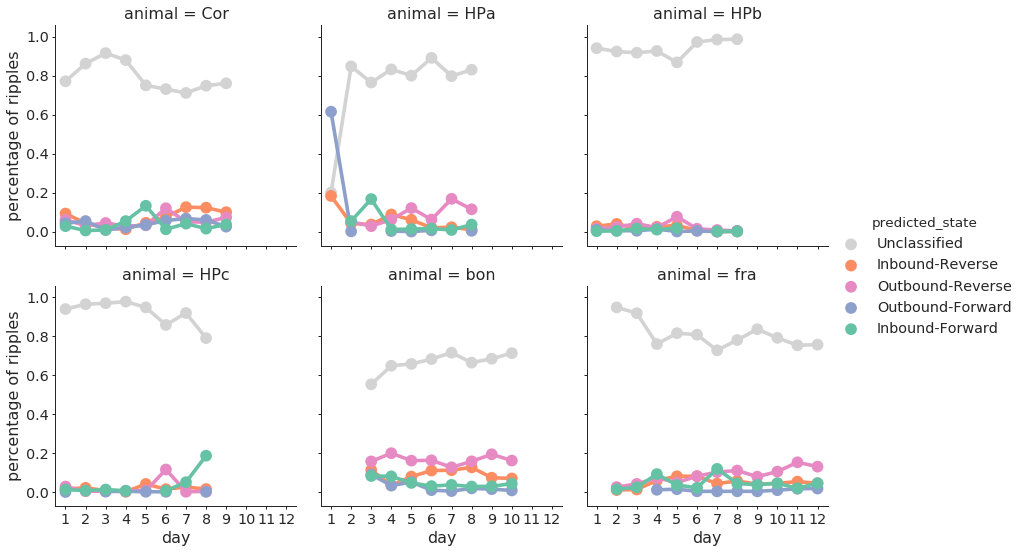

In [18]:
covariate = 'predicted_state'
percentage_of_ripples = (replay_info.reset_index()
 .groupby(['animal', 'day'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='day', y='percentage of ripples',
               hue=covariate, col='animal', col_wrap=3, palette=COLORS);

## Within session

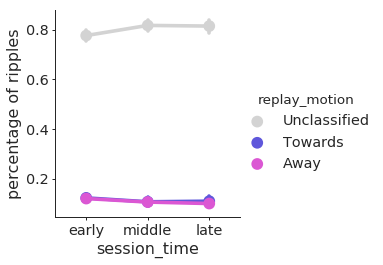

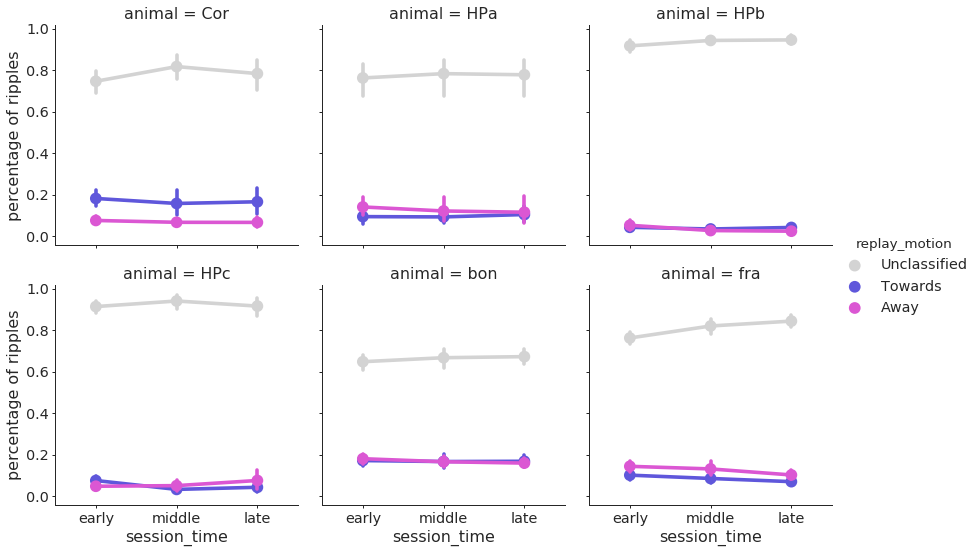

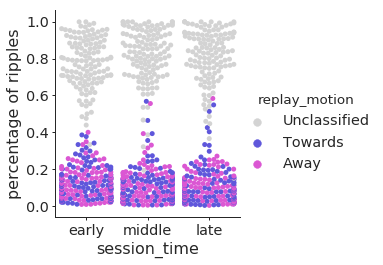

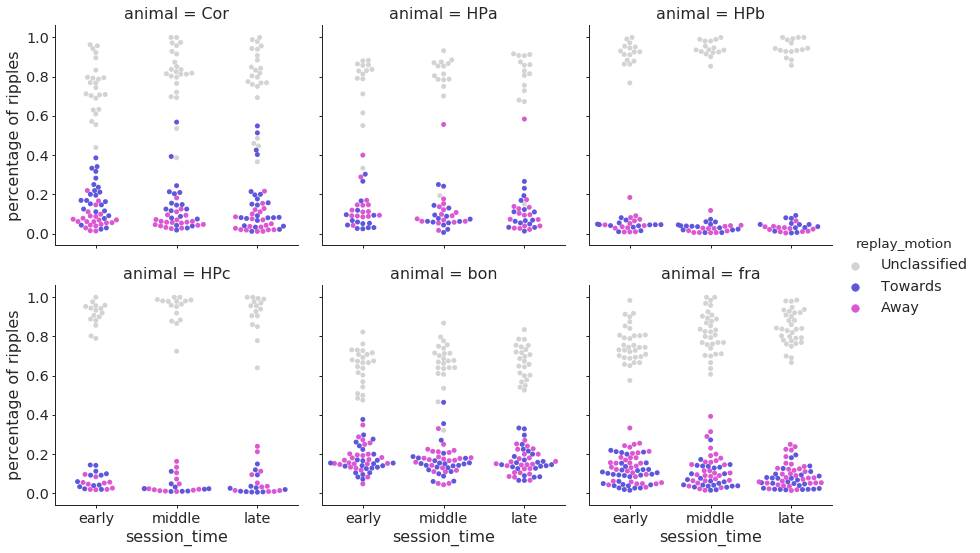

In [19]:
covariate = 'replay_motion'
percentage_of_ripples = (replay_info
 .groupby(['animal', 'day', 'epoch', 'session_time'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate, palette=COLORS);
sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate,
               col='animal', palette=COLORS, col_wrap=3);
sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate,
               kind='swarm', palette=COLORS);
sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate,
               col='animal', col_wrap=3, kind='swarm', palette=COLORS);

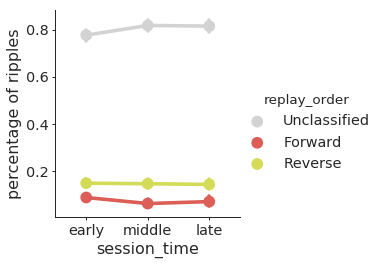

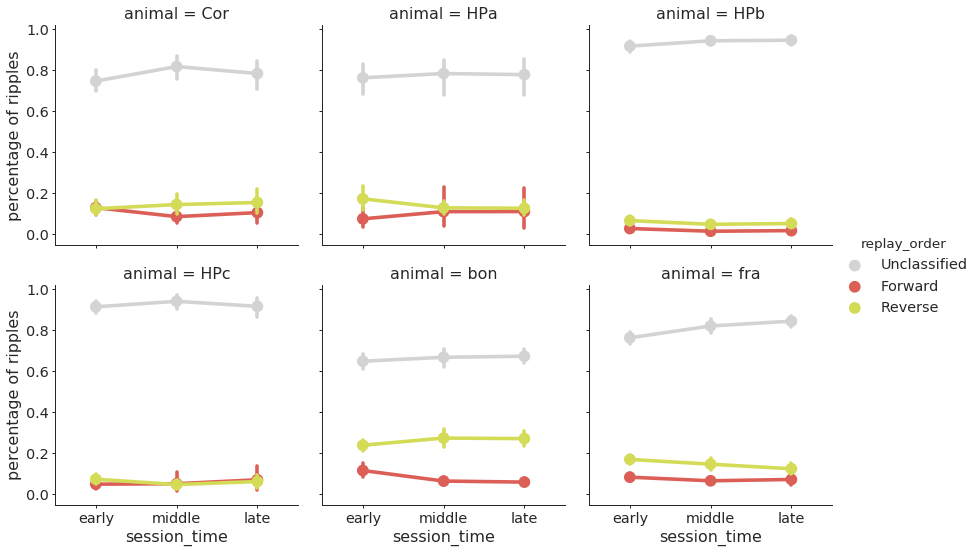

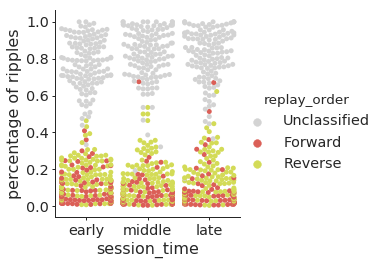

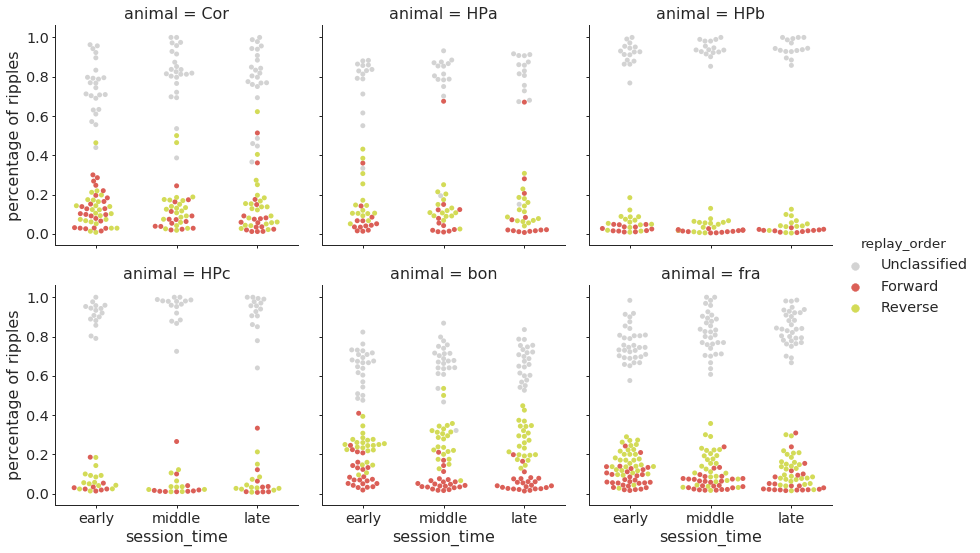

In [20]:
covariate = 'replay_order'
percentage_of_ripples = (replay_info
 .groupby(['animal', 'day', 'epoch', 'session_time'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate, palette=COLORS);
sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate,
               col='animal', palette=COLORS, col_wrap=3);
sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate,
               kind='swarm', palette=COLORS);
sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate,
               col='animal', col_wrap=3, kind='swarm', palette=COLORS);

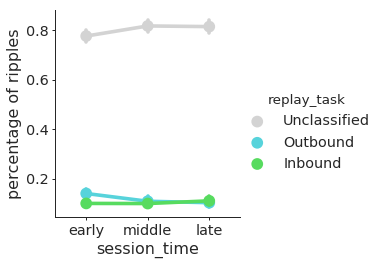

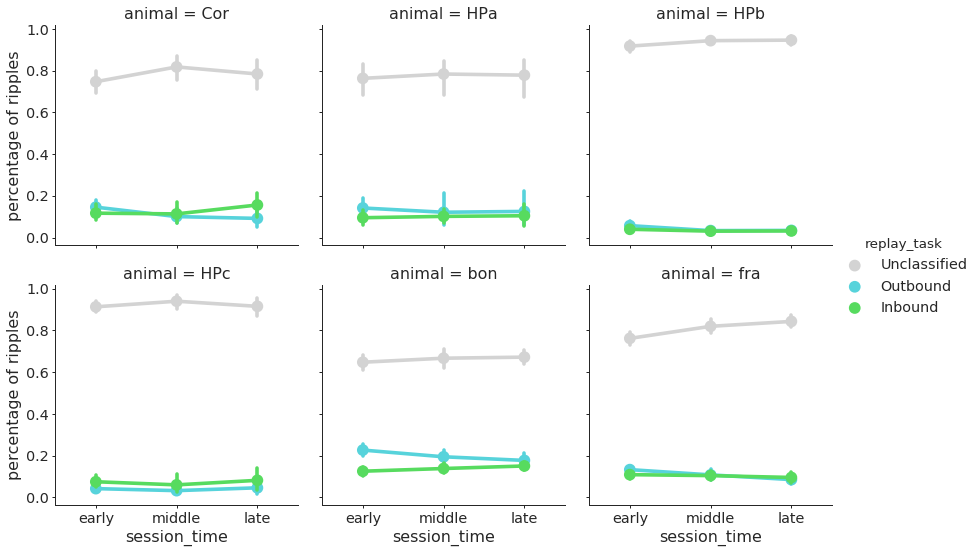

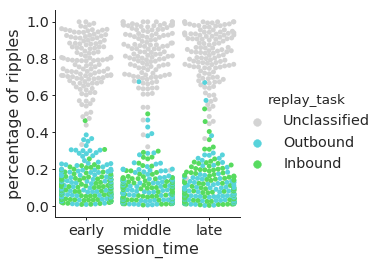

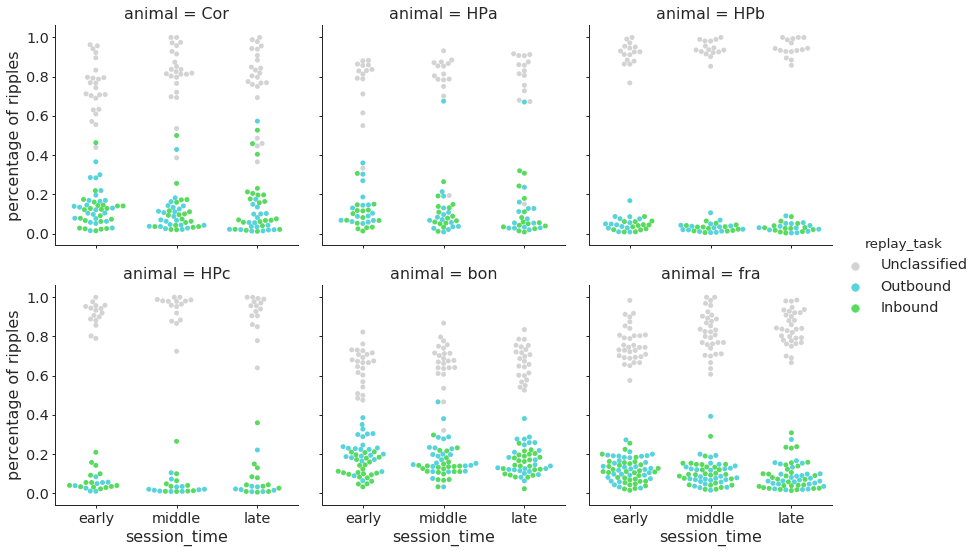

In [21]:
covariate = 'replay_task'
percentage_of_ripples = (replay_info
 .groupby(['animal', 'day', 'epoch', 'session_time'])[covariate].value_counts(normalize=True)
 .rename('percentage of ripples').reset_index())

sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate, palette=COLORS);
sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate,
               col='animal', palette=COLORS, col_wrap=3);
sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate,
               kind='swarm', palette=COLORS);
sns.factorplot(data=percentage_of_ripples, x='session_time', y='percentage of ripples', hue=covariate,
               col='animal', col_wrap=3, kind='swarm', palette=COLORS);

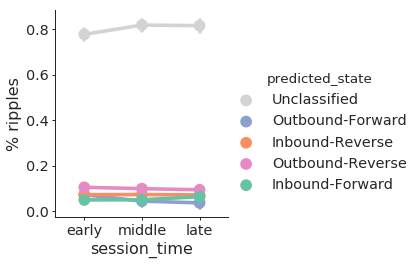

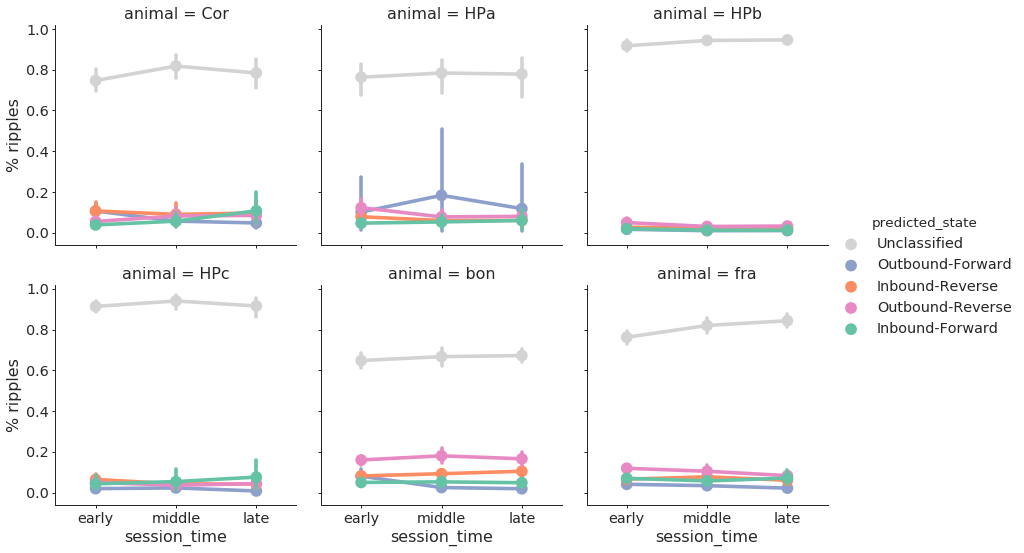

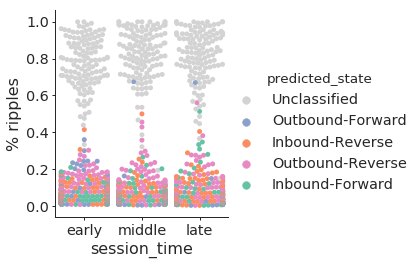

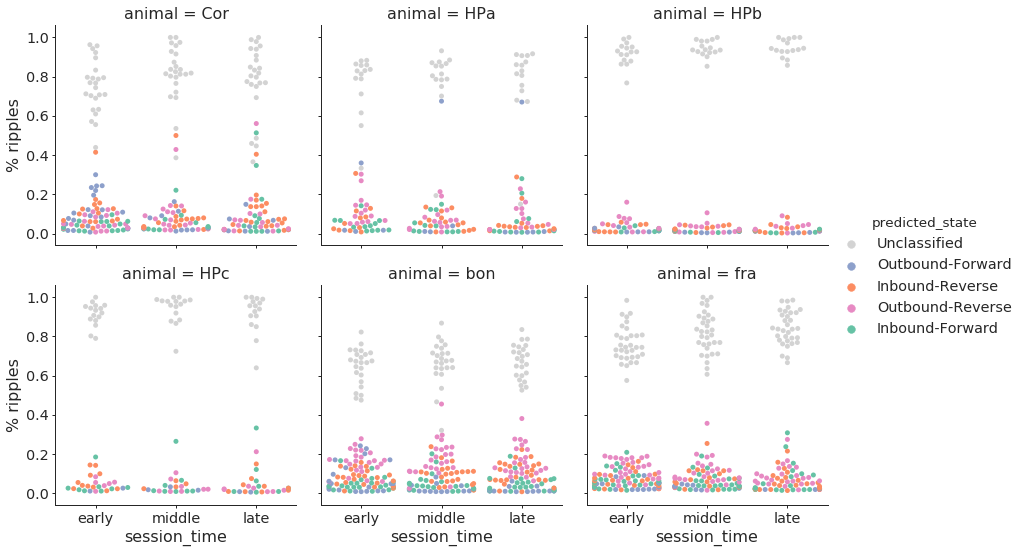

In [22]:
covariate = 'predicted_state'
replay_percentage = (replay_info
 .groupby(['animal', 'day', 'epoch', 'session_time'])[covariate].value_counts(normalize=True)
 .rename('% ripples').reset_index())

sns.factorplot(data=replay_percentage, x='session_time', y='% ripples', hue=covariate, palette=COLORS);
sns.factorplot(data=replay_percentage, x='session_time', y='% ripples',
               hue=covariate, col='animal', col_wrap=3, palette=COLORS);
sns.factorplot(data=replay_percentage, x='session_time', y='% ripples',
               hue=covariate, kind='swarm', palette=COLORS);
sns.factorplot(data=replay_percentage, x='session_time', y='% ripples', hue=covariate,
               col='animal', col_wrap=3, kind='swarm', palette=COLORS);

## Position of Animal during Replay Types

In [23]:
position_occupancy = (
    xr.open_mfdataset(PROCESSED_DATA_DIR + '/*.nc', group='position_occupancy')
    .to_dataframe()
    .set_index(['animal', 'day', 'epoch']))

In [24]:
po = position_occupancy.groupby(['animal', 'environment', 'center_x', 'center_y']).sum()

In [25]:
replay_info = (replay_info
               .reset_index('ripple_number')
               .join(epoch_info.environment.astype(str))
               .set_index('ripple_number', append=True))

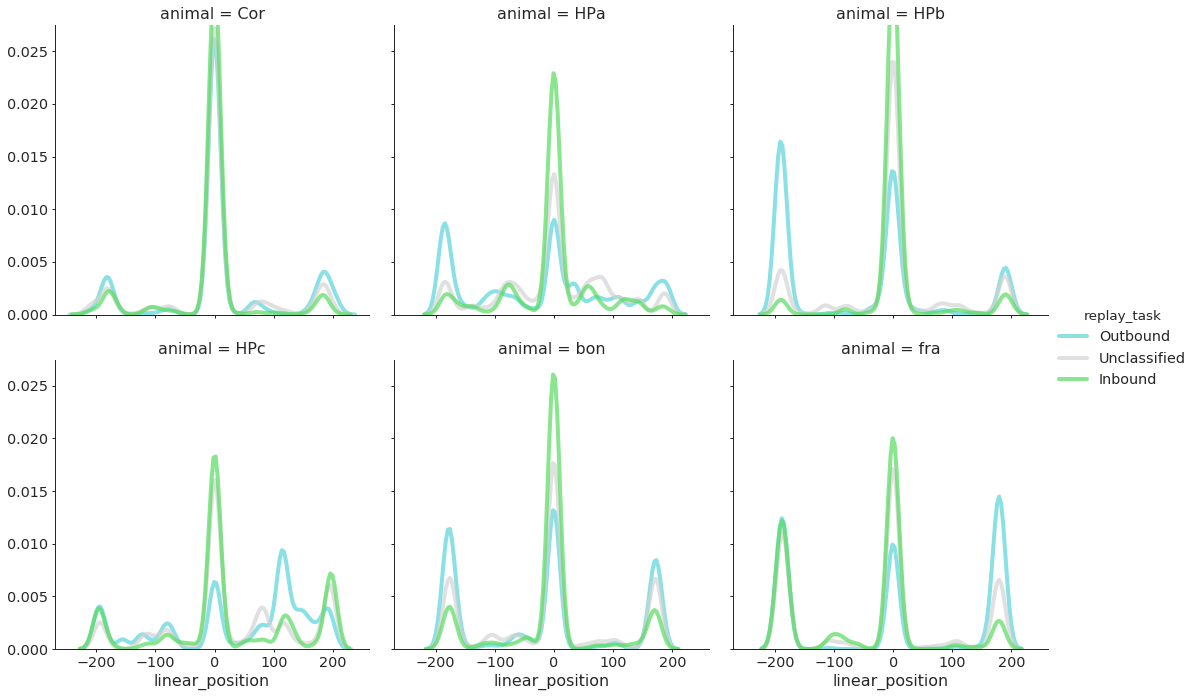

In [26]:
covariate = 'replay_task'
g = sns.FacetGrid(replay_info.reset_index(), col='animal', hue=covariate, size=5, col_wrap=3, palette=COLORS)
g.map(sns.kdeplot, 'linear_position', alpha=0.7, bw=10, linewidth=4);
g.add_legend();

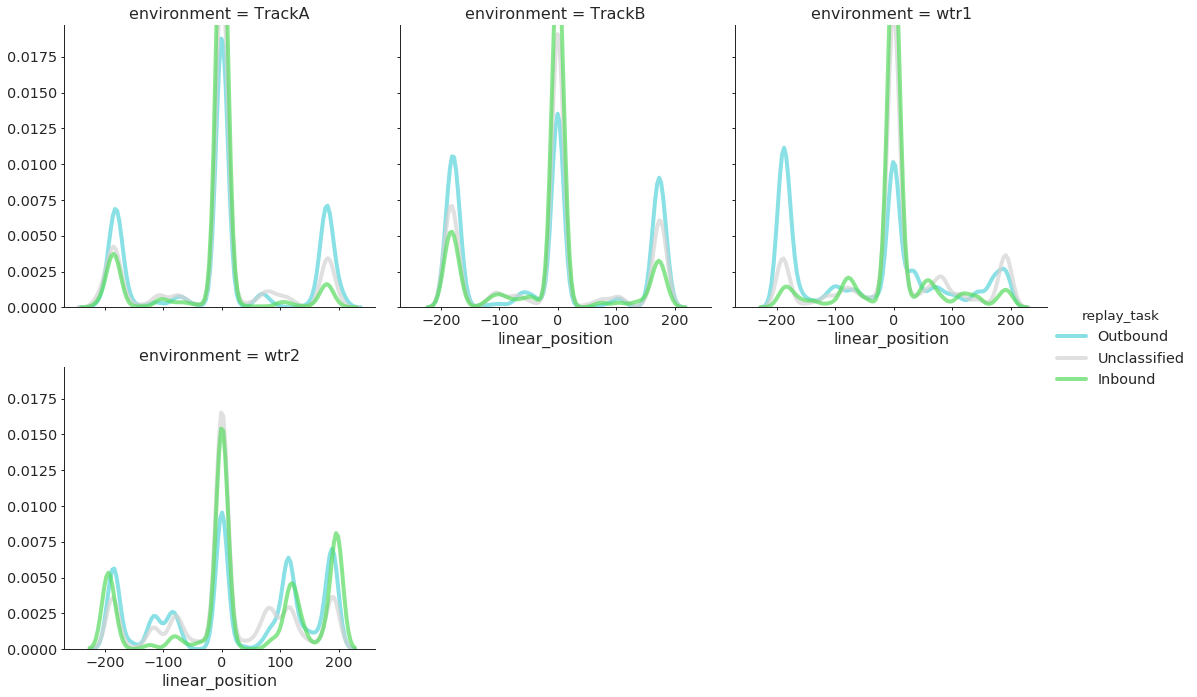

In [27]:
covariate = 'replay_task'
g = sns.FacetGrid(replay_info.reset_index(), col='environment', hue=covariate, size=5, col_wrap=3, palette=COLORS)
g.map(sns.kdeplot, 'linear_position', alpha=0.7, bw=10, linewidth=4);
g.add_legend();

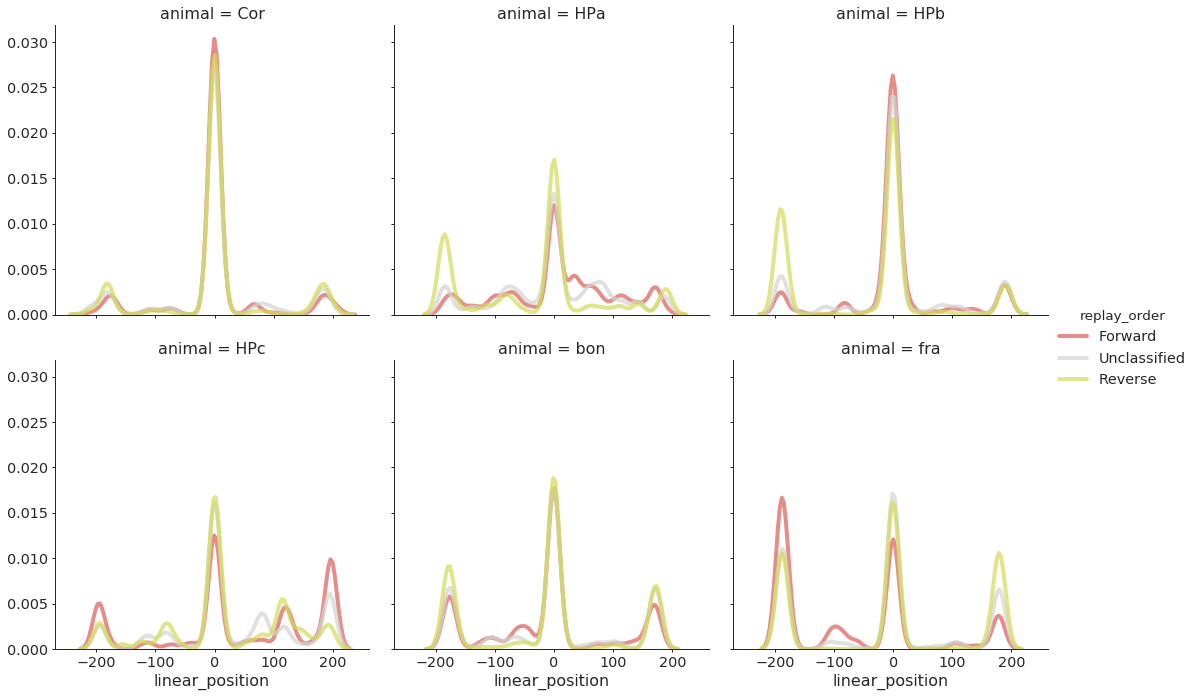

In [28]:
covariate = 'replay_order'
g = sns.FacetGrid(replay_info.reset_index(), col='animal', hue=covariate, size=5, col_wrap=3, palette=COLORS)
g.map(sns.kdeplot, 'linear_position', alpha=0.7, bw=10, linewidth=4);
g.add_legend();

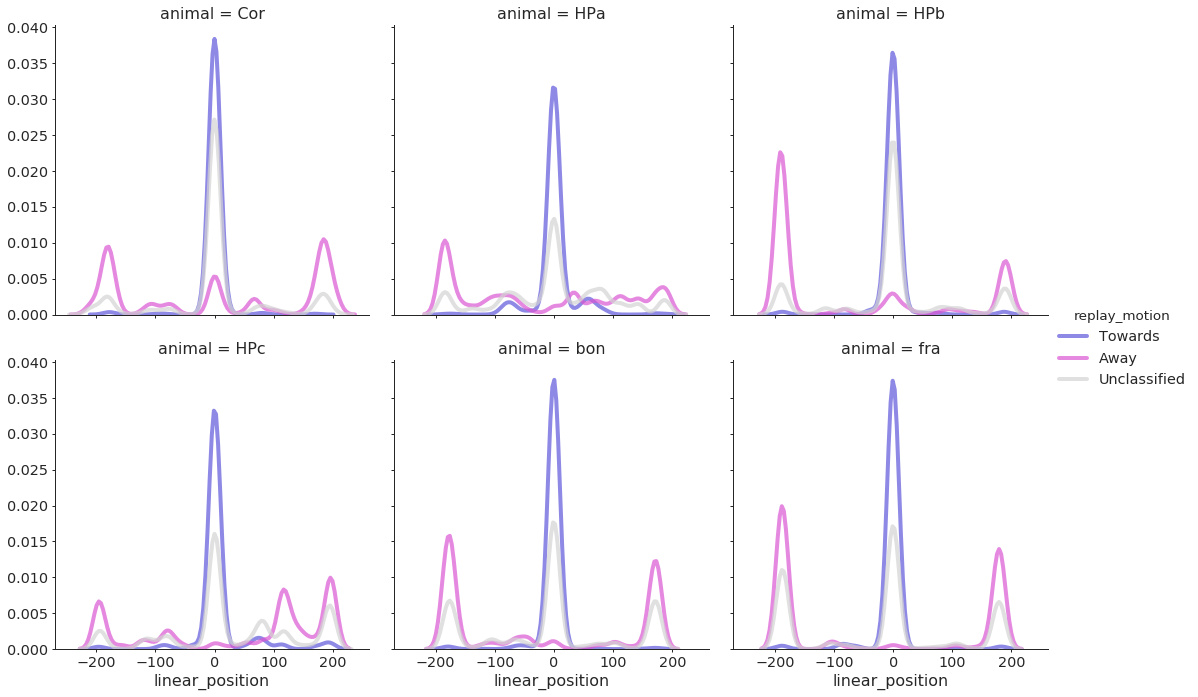

In [29]:
covariate = 'replay_motion'
g = sns.FacetGrid(replay_info.reset_index(), col='animal', hue=covariate, size=5, col_wrap=3, palette=COLORS)
g.map(sns.kdeplot, 'linear_position', alpha=0.7, bw=10, linewidth=4);
g.add_legend();

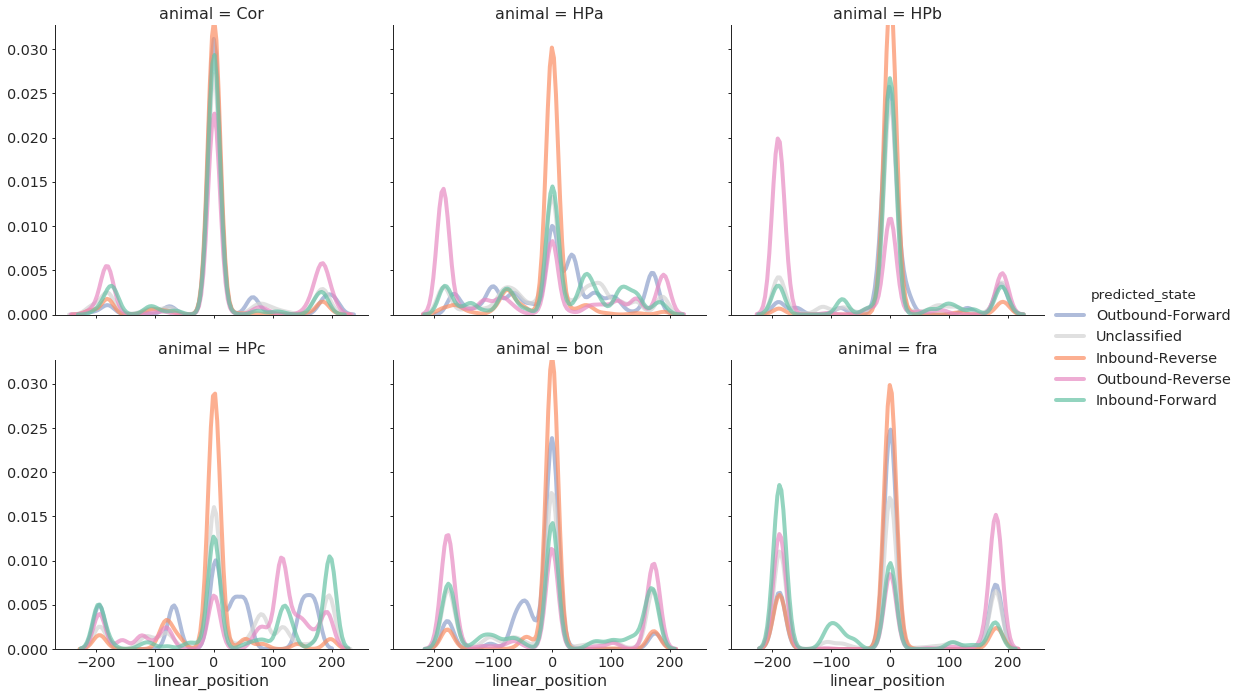

In [30]:
covariate = 'predicted_state'
g = sns.FacetGrid(replay_info.reset_index(), col='animal', hue=covariate, size=5, col_wrap=3, palette=COLORS)
g.map(sns.kdeplot, 'linear_position', alpha=0.7, bw=10, linewidth=4);
g.add_legend();

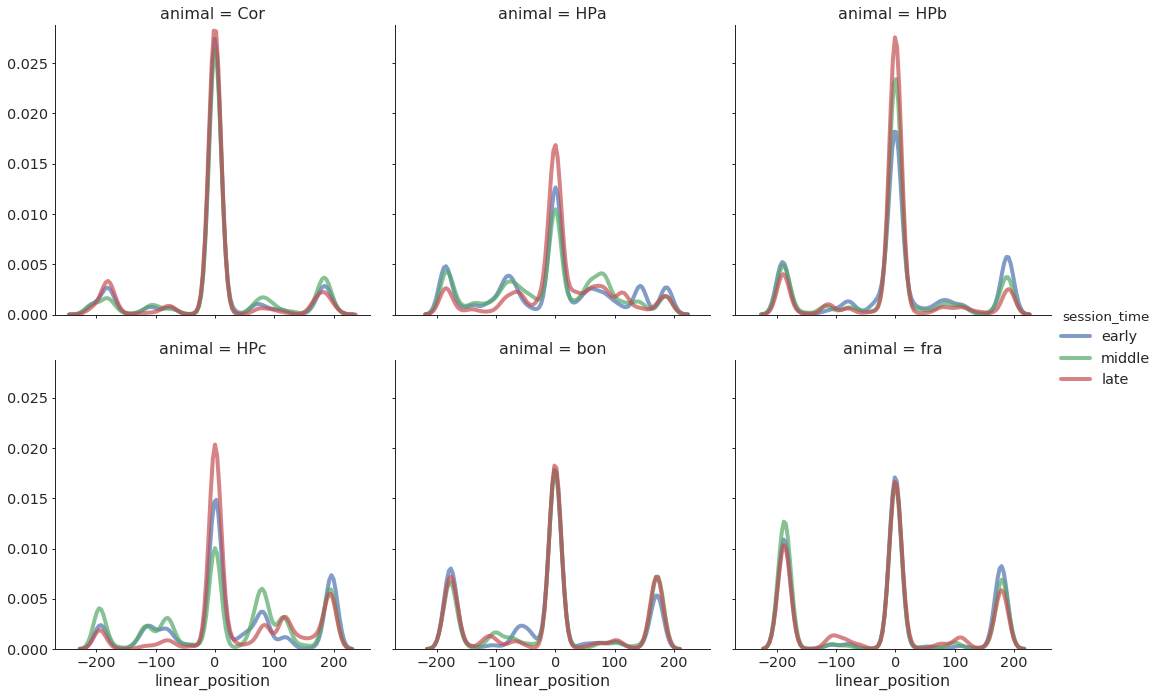

In [31]:
covariate = 'session_time'
g = sns.FacetGrid(replay_info.reset_index(), col='animal', hue=covariate, size=5, col_wrap=3)
g.map(sns.kdeplot, 'linear_position', alpha=0.7, bw=10, linewidth=4);
g.add_legend();

### Occupancy Normalized 

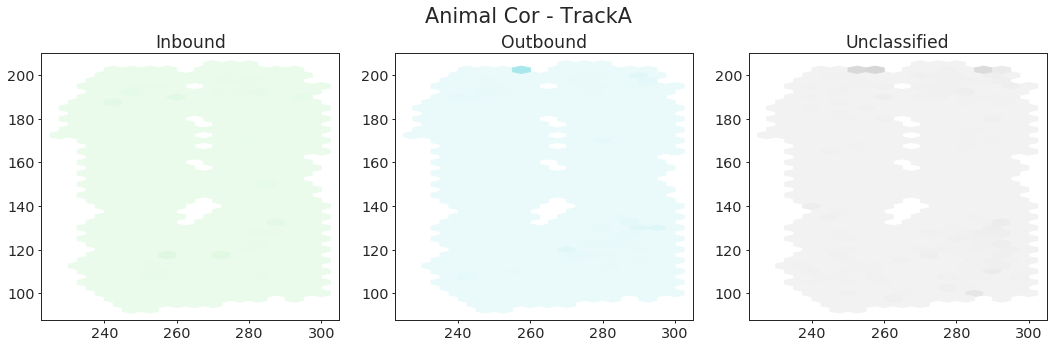

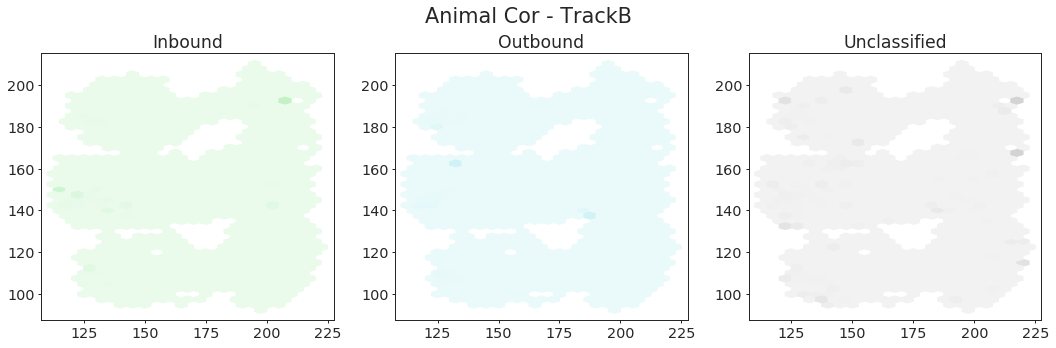

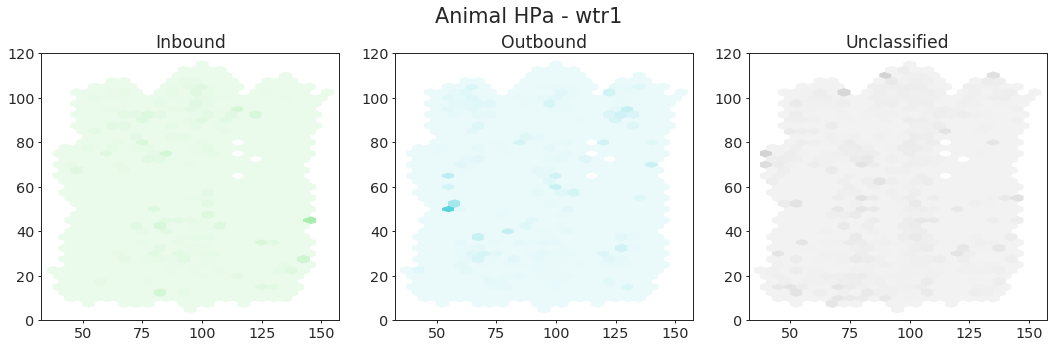

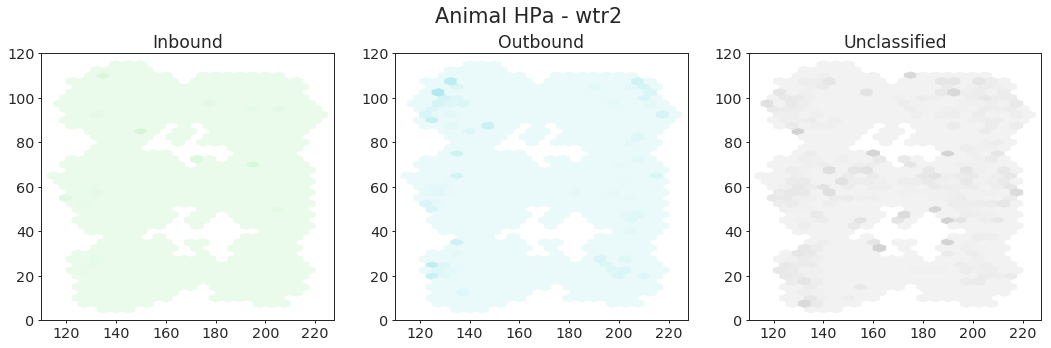

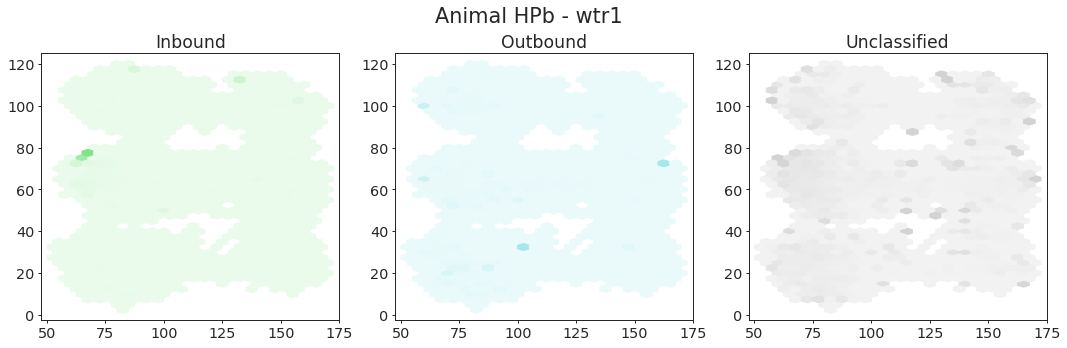

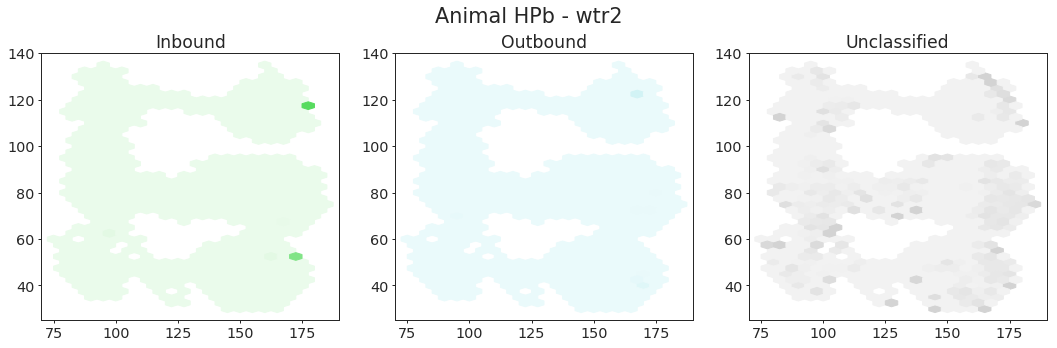

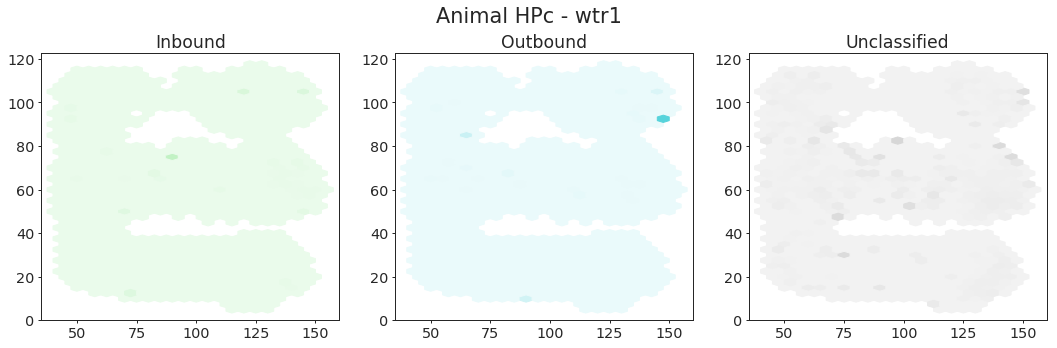

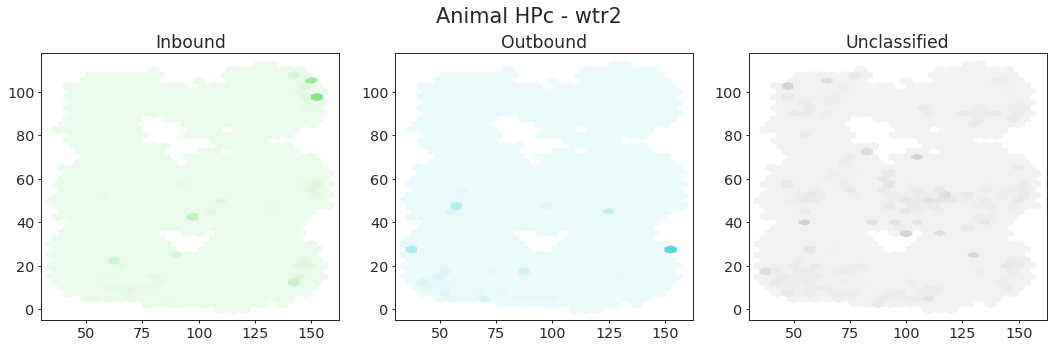

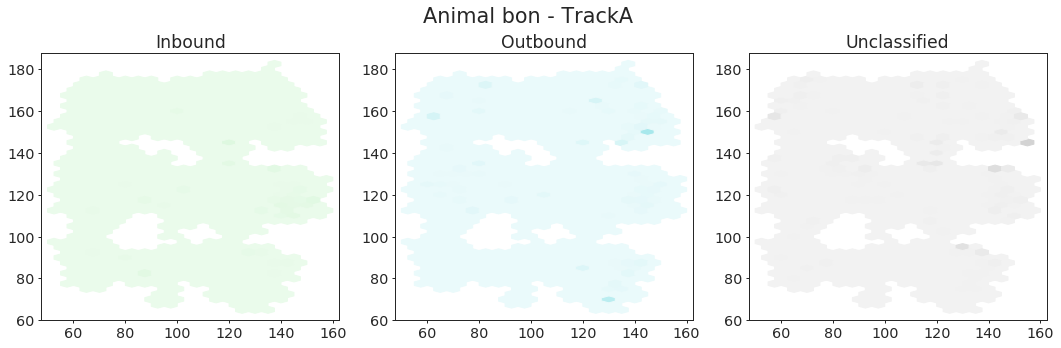

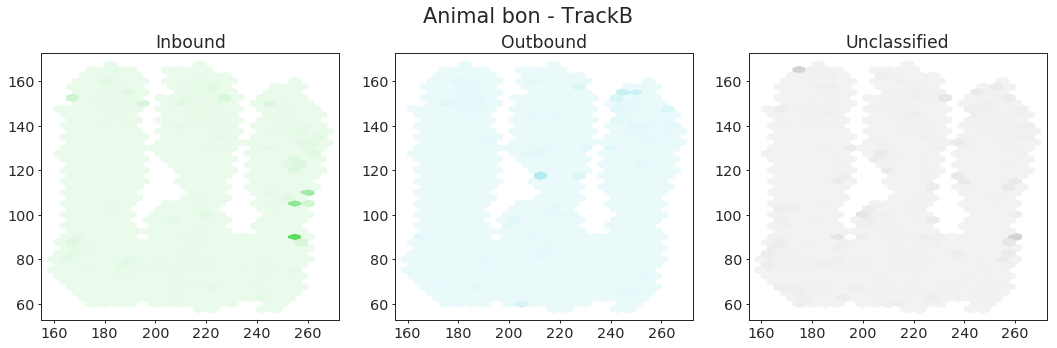

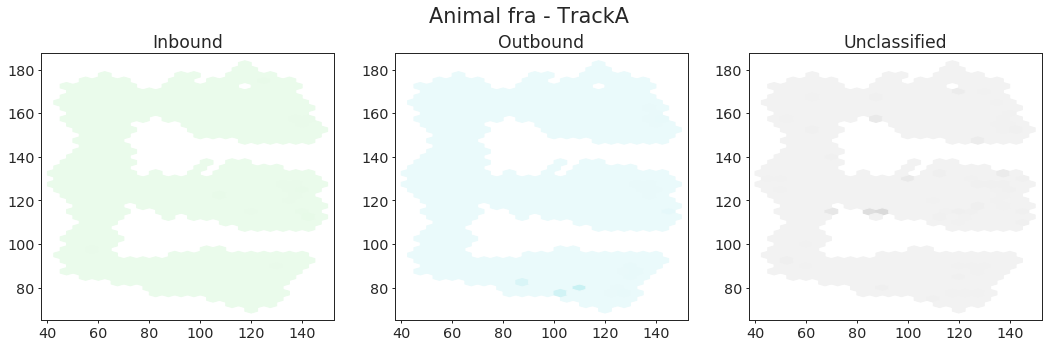

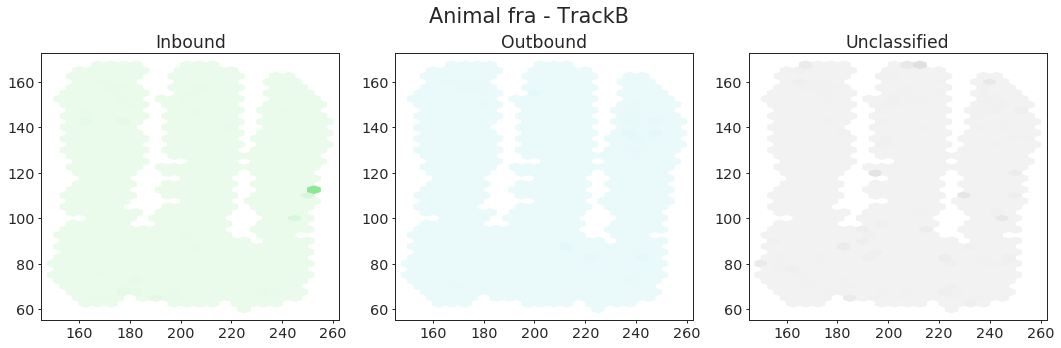

In [32]:
from src.parameters import GRIDSIZE, EXTENT, SAMPLING_FREQUENCY

covariate = 'replay_task'
for name, group in replay_info.groupby(['animal', 'environment']):
    grouped = group.groupby(covariate)
    n_levels = len(grouped)
    fig, axes = plt.subplots(1, n_levels, figsize=(5 * n_levels, 5), sharex=True, sharey=True)
    occupancy = po.xs(name[:2]).reset_index().set_index(['center_x', 'center_y']).sort_index()
    for ax, (level, level_group) in zip(axes, grouped):
        event_count = ax.hexbin(level_group.x_position, level_group.y_position,
                                gridsize=GRIDSIZE, extent=EXTENT);
        ax.cla()
        event_count = pd.DataFrame(
                {'event_count': event_count.get_array(),
                 'center_x': event_count.get_offsets()[:, 0],
                 'center_y': event_count.get_offsets()[:, 1]}).set_index(['center_x', 'center_y']).sort_index()
        normalized_count = pd.concat((event_count, occupancy), axis=1).reset_index()
        normalized_count['normalized_count'] = (
            SAMPLING_FREQUENCY * normalized_count.event_count / normalized_count.occupancy_count)
        mappable = ax.hexbin(normalized_count.center_x, normalized_count.center_y,
                             C=normalized_count.normalized_count, gridsize=GRIDSIZE, extent=EXTENT,
                             cmap=sns.light_palette(COLORS[level], as_cmap=True), vmin=0, vmax=2)
#         ax.scatter(level_group.x_position, level_group.y_position, color='red', s=2)
        ax.set_title(level)
        xlim = np.percentile(
            normalized_count.center_x[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ylim = np.percentile(
            normalized_count.center_y[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ax.set_xlim(xlim + [-5, 5])
        ax.set_ylim(ylim + [-5, 5])
    fig.suptitle('Animal {0} - {1}'.format(*name))
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

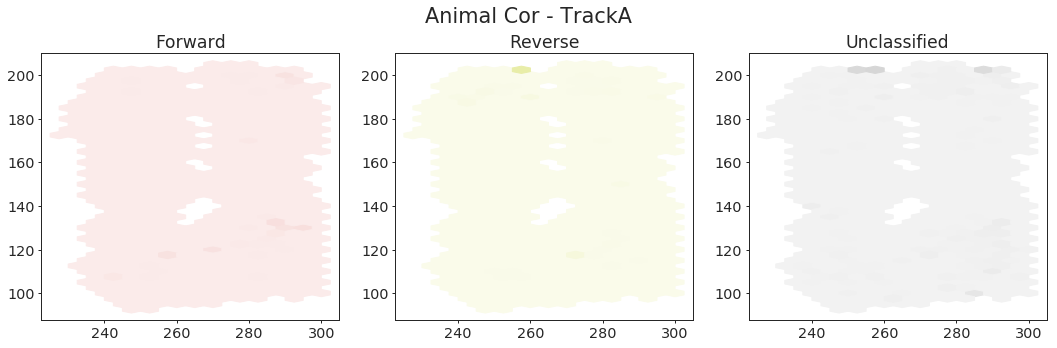

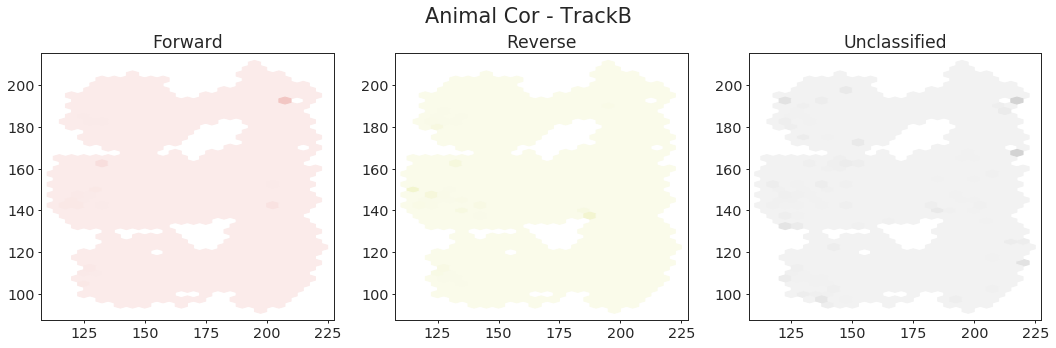

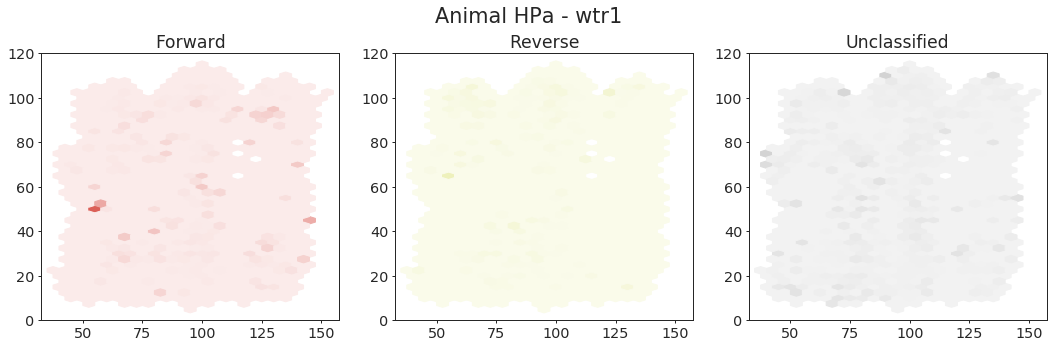

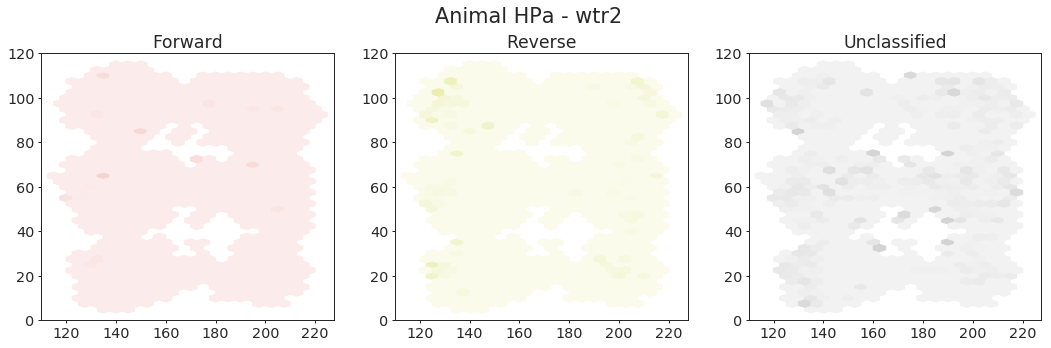

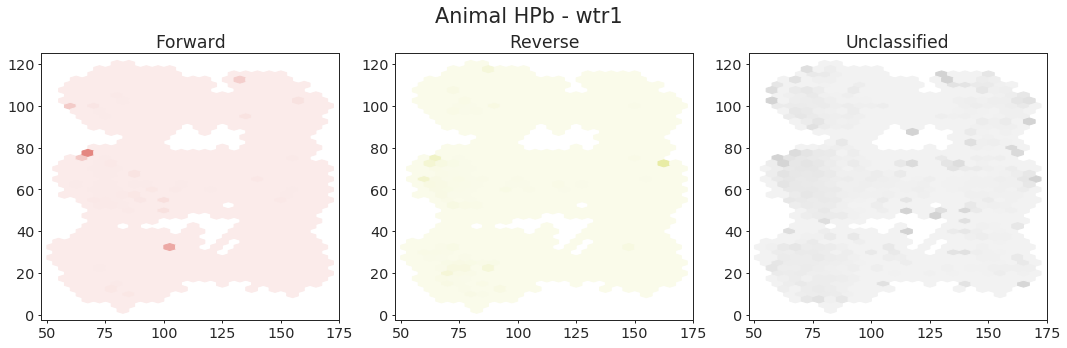

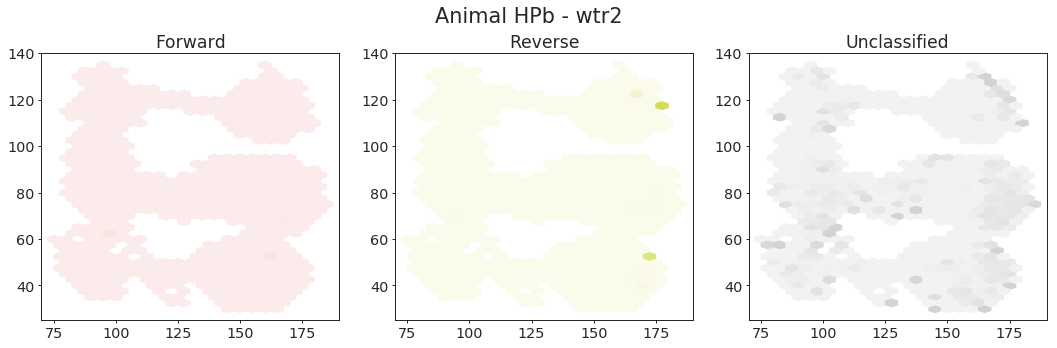

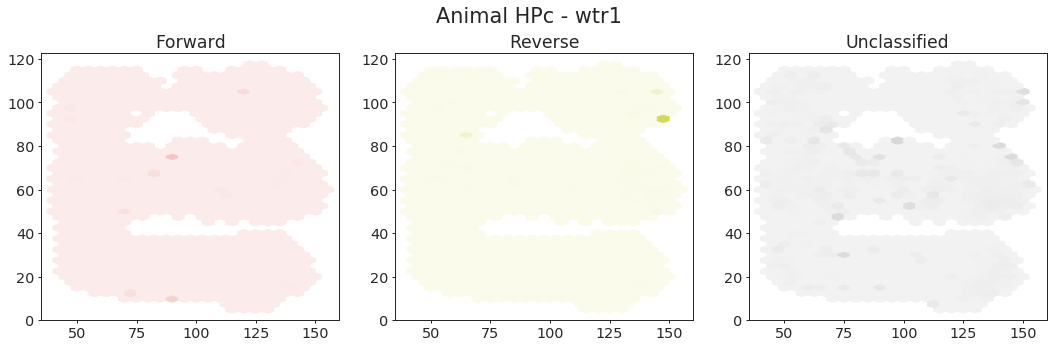

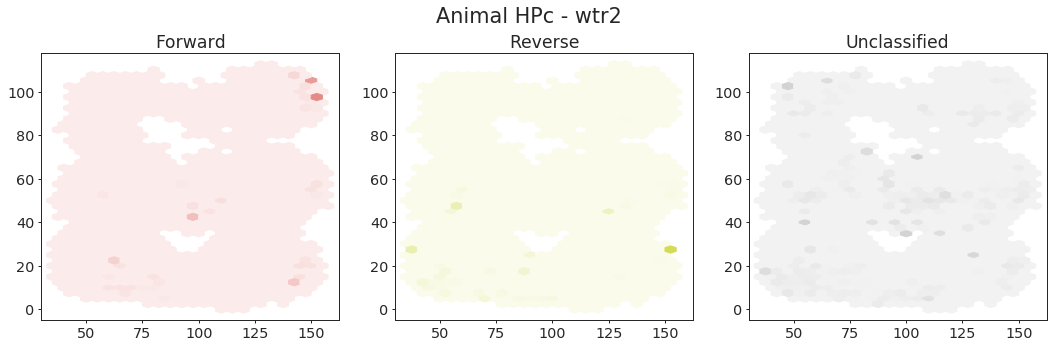

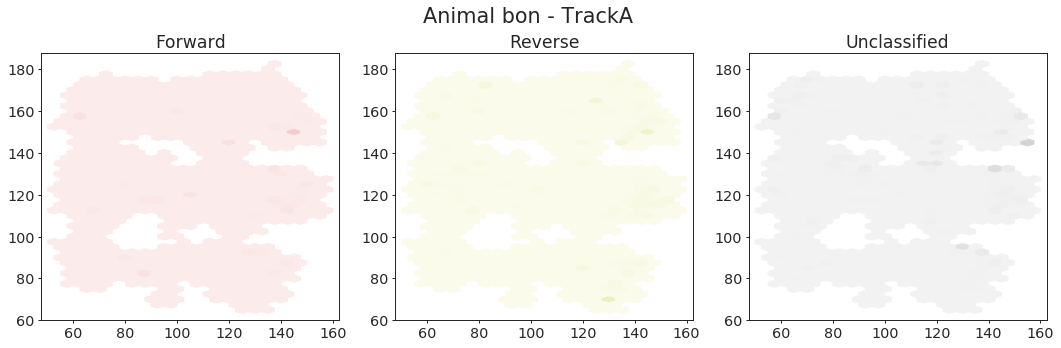

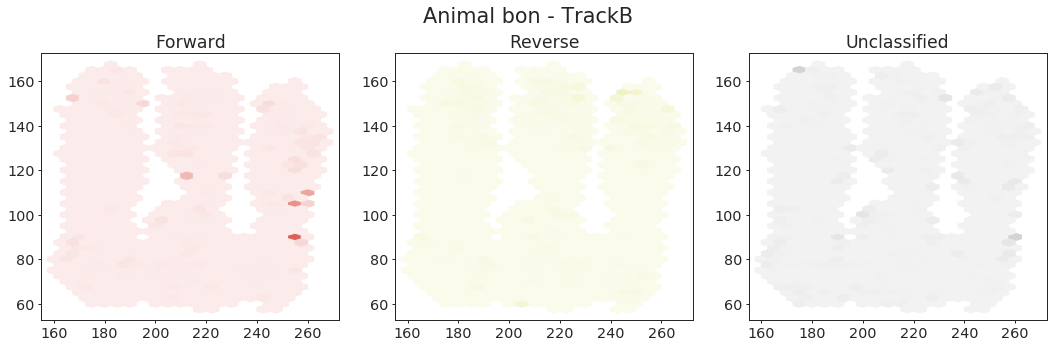

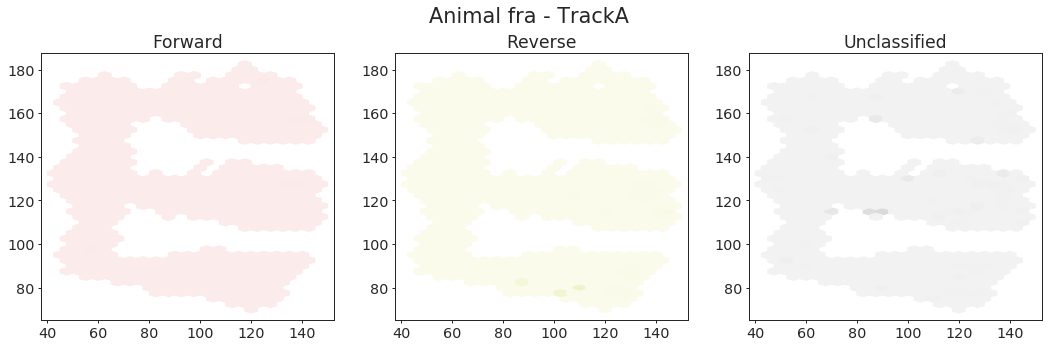

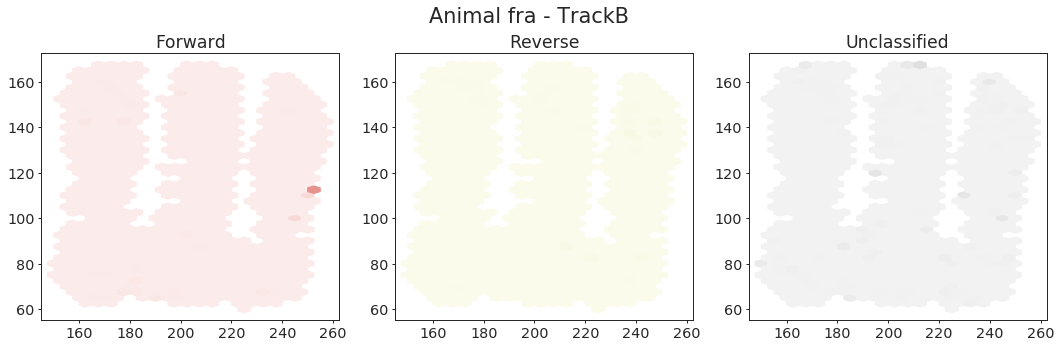

In [33]:
from src.parameters import GRIDSIZE, EXTENT, SAMPLING_FREQUENCY

covariate = 'replay_order'
for name, group in replay_info.groupby(['animal', 'environment']):
    grouped = group.groupby(covariate)
    n_levels = len(grouped)
    fig, axes = plt.subplots(1, n_levels, figsize=(5 * n_levels, 5), sharex=True, sharey=True)
    occupancy = po.xs(name[:2]).reset_index().set_index(['center_x', 'center_y']).sort_index()
    for ax, (level, level_group) in zip(axes, grouped):
        event_count = ax.hexbin(level_group.x_position, level_group.y_position,
                                gridsize=GRIDSIZE, extent=EXTENT);
        ax.cla()
        event_count = pd.DataFrame(
                {'event_count': event_count.get_array(),
                 'center_x': event_count.get_offsets()[:, 0],
                 'center_y': event_count.get_offsets()[:, 1]}).set_index(['center_x', 'center_y']).sort_index()
        normalized_count = pd.concat((event_count, occupancy), axis=1).reset_index()
        normalized_count['normalized_count'] = (
            SAMPLING_FREQUENCY * normalized_count.event_count / normalized_count.occupancy_count)
        mappable = ax.hexbin(normalized_count.center_x, normalized_count.center_y,
                             C=normalized_count.normalized_count, gridsize=GRIDSIZE, extent=EXTENT,
                             cmap=sns.light_palette(COLORS[level], as_cmap=True), vmin=0, vmax=2)
#         ax.scatter(level_group.x_position, level_group.y_position, color='red', s=2)
        ax.set_title(level)
        xlim = np.percentile(
            normalized_count.center_x[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ylim = np.percentile(
            normalized_count.center_y[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ax.set_xlim(xlim + [-5, 5])
        ax.set_ylim(ylim + [-5, 5])
    fig.suptitle('Animal {0} - {1}'.format(*name))
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

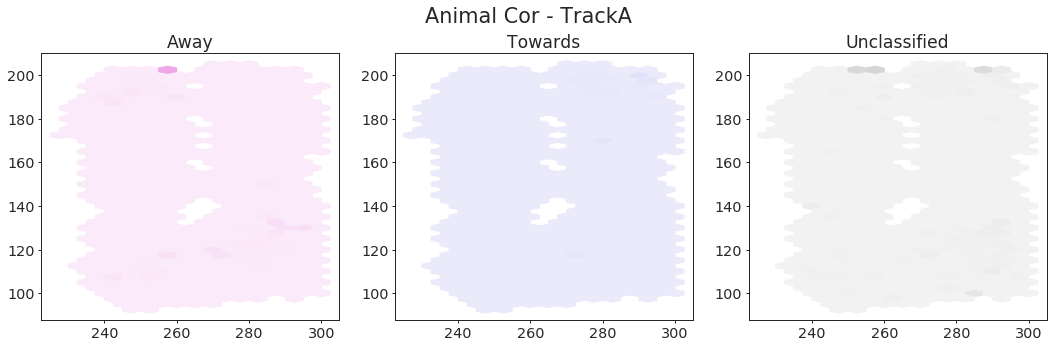

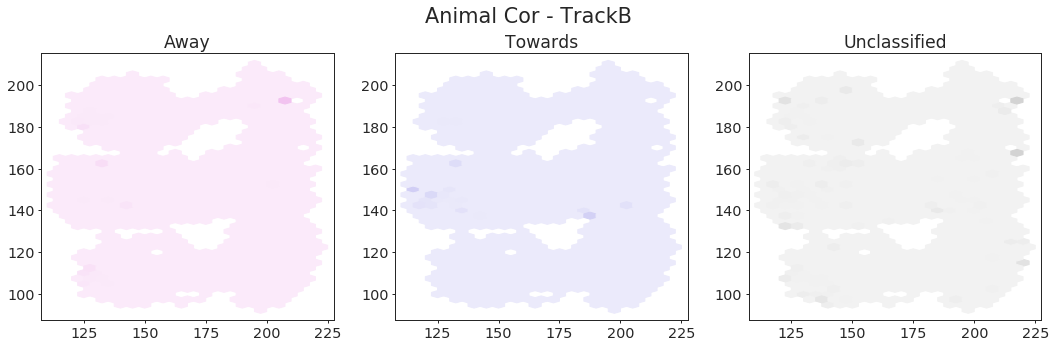

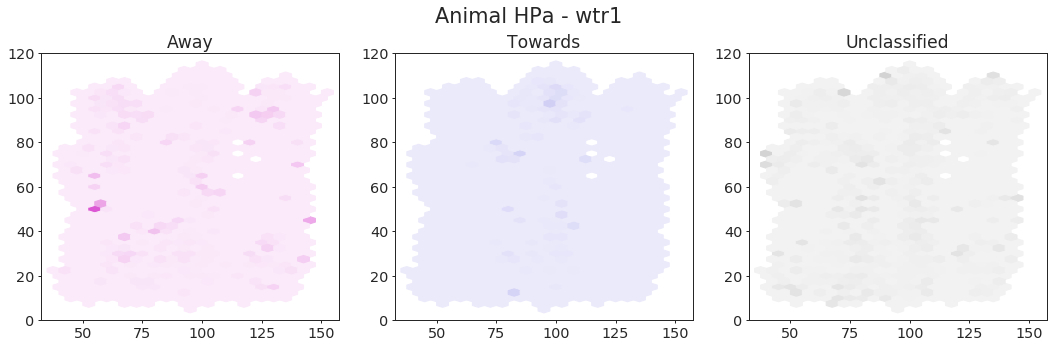

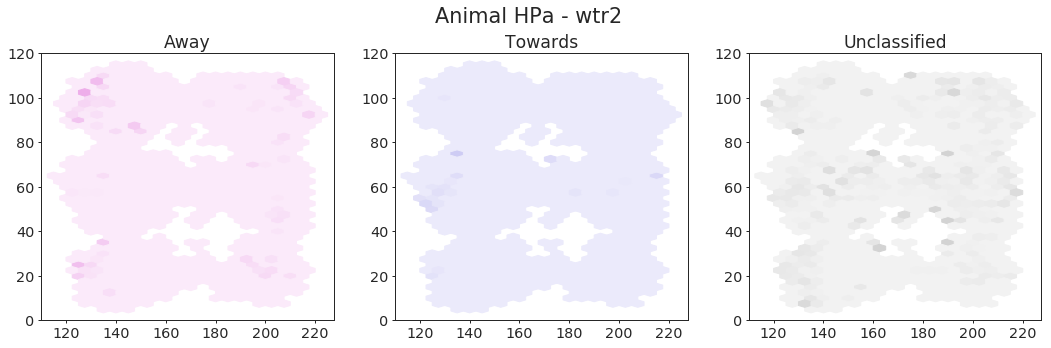

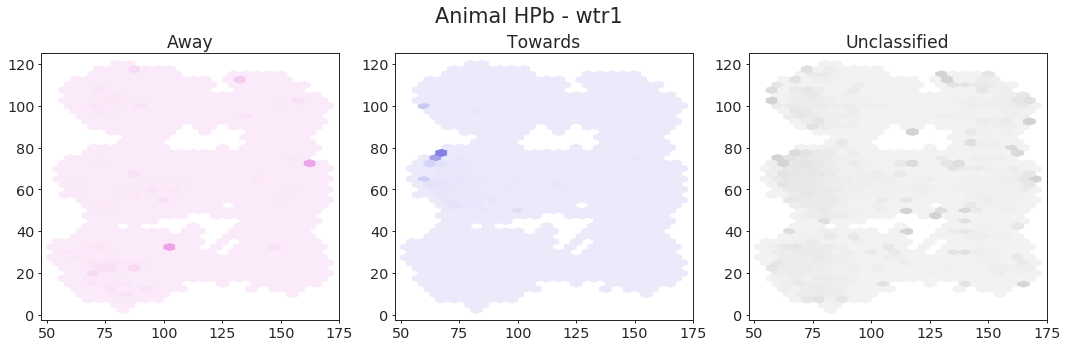

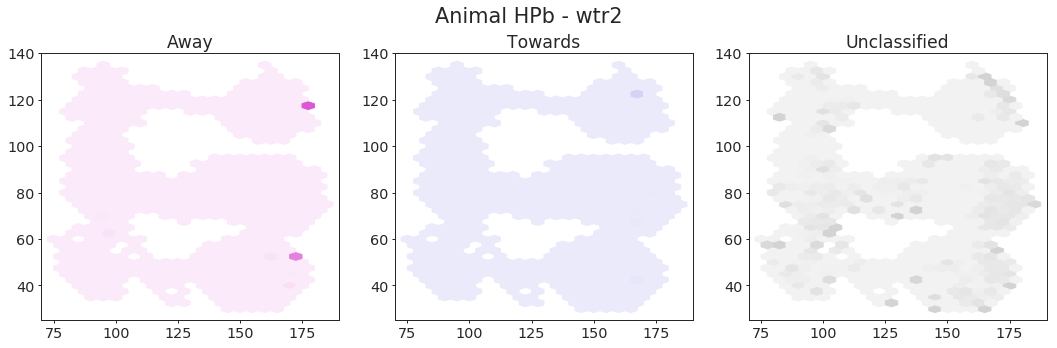

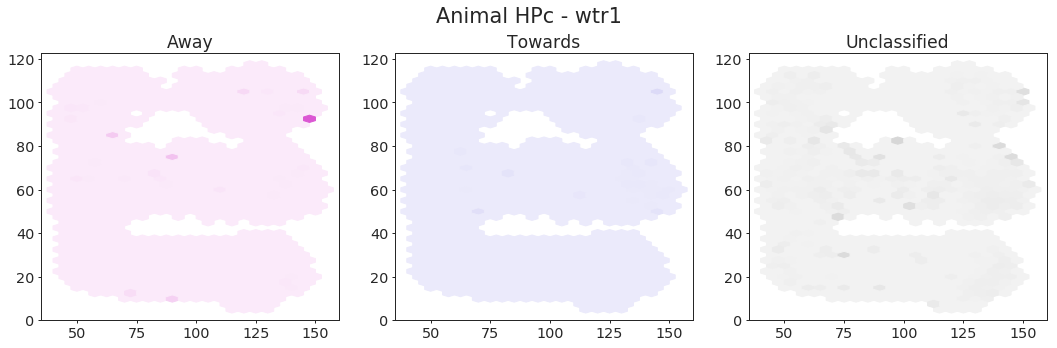

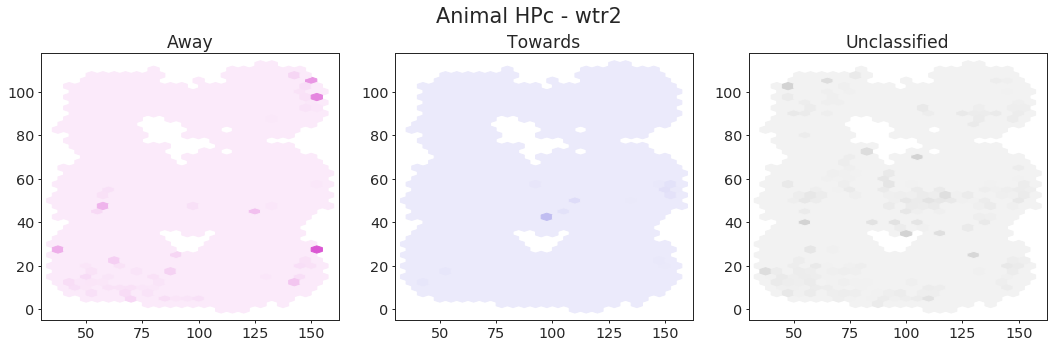

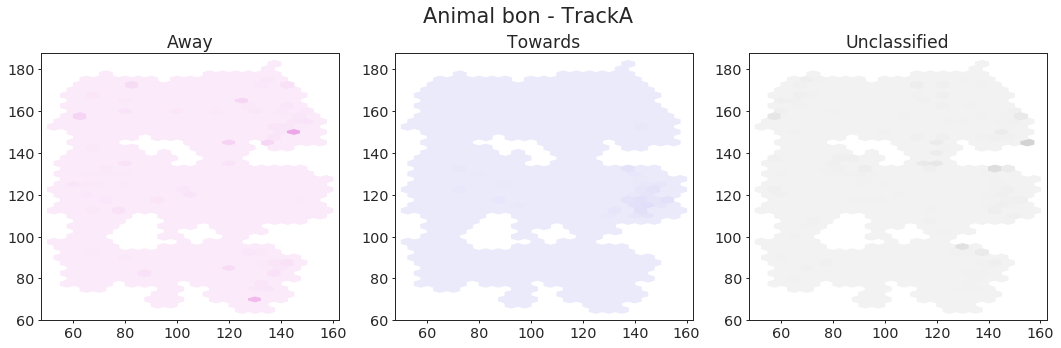

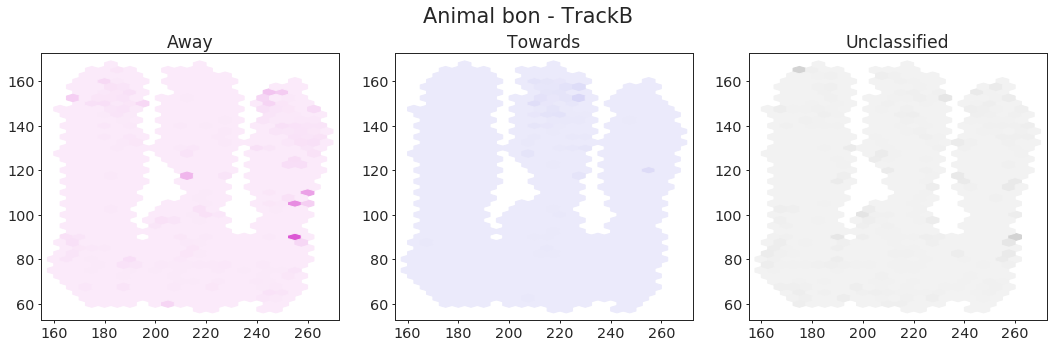

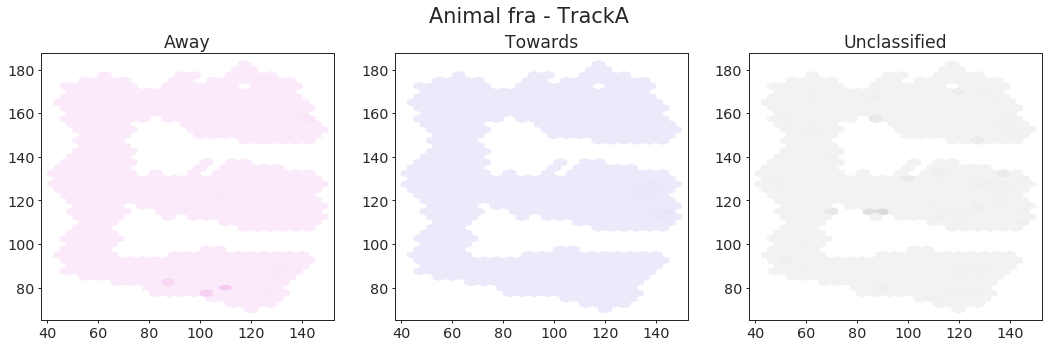

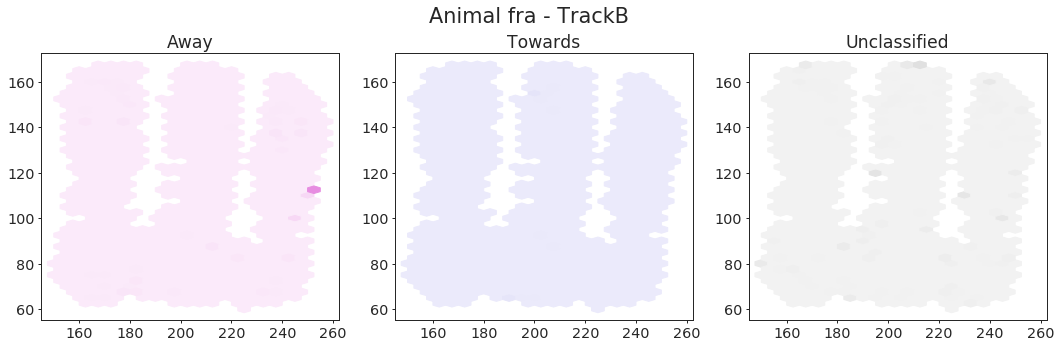

In [34]:
from src.parameters import GRIDSIZE, EXTENT, SAMPLING_FREQUENCY

covariate = 'replay_motion'
for name, group in replay_info.groupby(['animal', 'environment']):
    grouped = group.groupby(covariate)
    n_levels = len(grouped)
    fig, axes = plt.subplots(1, n_levels, figsize=(5 * n_levels, 5), sharex=True, sharey=True)
    occupancy = po.xs(name[:2]).reset_index().set_index(['center_x', 'center_y']).sort_index()
    for ax, (level, level_group) in zip(axes, grouped):
        event_count = ax.hexbin(level_group.x_position, level_group.y_position,
                                gridsize=GRIDSIZE, extent=EXTENT);
        ax.cla()
        event_count = pd.DataFrame(
                {'event_count': event_count.get_array(),
                 'center_x': event_count.get_offsets()[:, 0],
                 'center_y': event_count.get_offsets()[:, 1]}).set_index(['center_x', 'center_y']).sort_index()
        normalized_count = pd.concat((event_count, occupancy), axis=1).reset_index()
        normalized_count['normalized_count'] = (
            SAMPLING_FREQUENCY * normalized_count.event_count / normalized_count.occupancy_count)
        mappable = ax.hexbin(normalized_count.center_x, normalized_count.center_y,
                             C=normalized_count.normalized_count, gridsize=GRIDSIZE, extent=EXTENT,
                             cmap=sns.light_palette(COLORS[level], as_cmap=True), vmin=0, vmax=2)
#         ax.scatter(level_group.x_position, level_group.y_position, color='red', s=2)
        ax.set_title(level)
        xlim = np.percentile(
            normalized_count.center_x[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ylim = np.percentile(
            normalized_count.center_y[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ax.set_xlim(xlim + [-5, 5])
        ax.set_ylim(ylim + [-5, 5])
    fig.suptitle('Animal {0} - {1}'.format(*name))
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

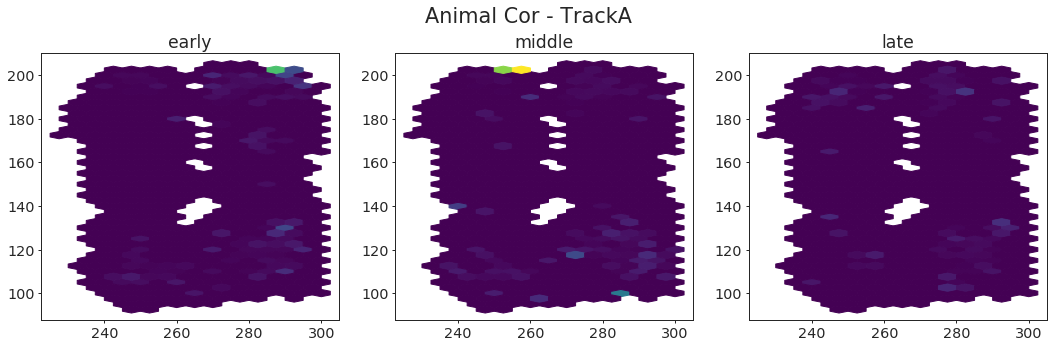

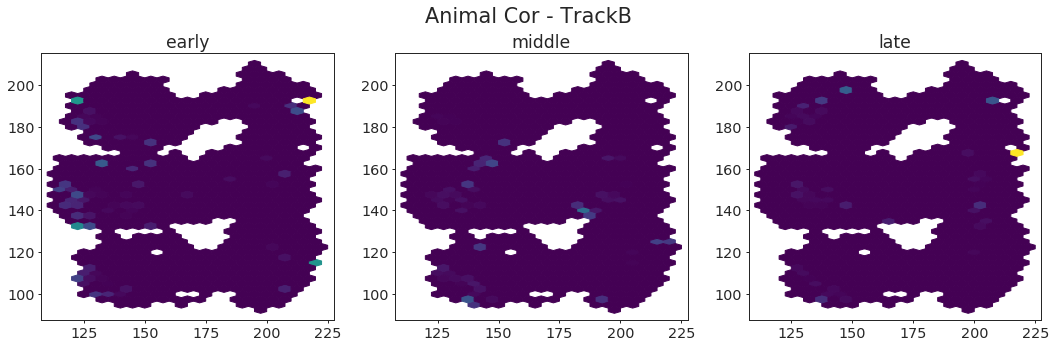

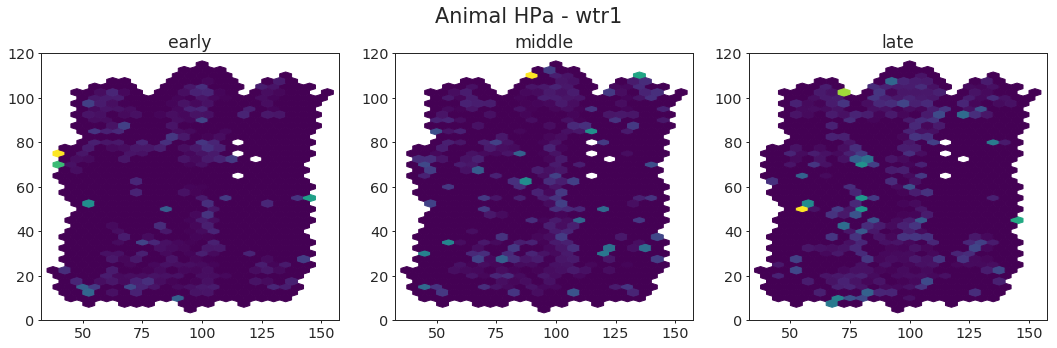

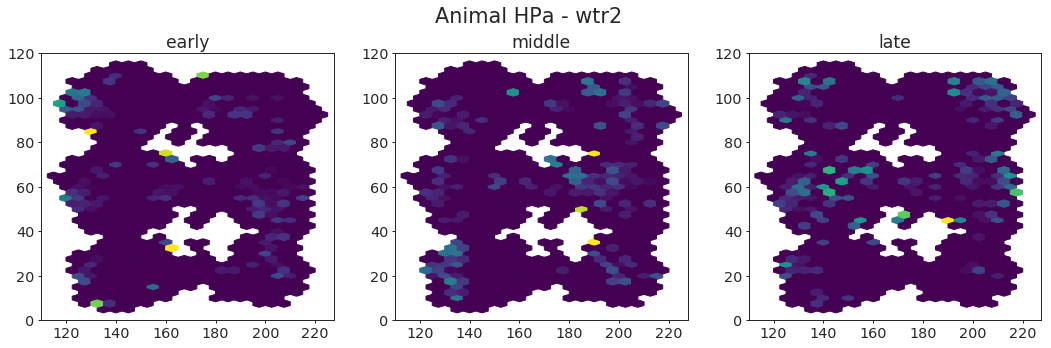

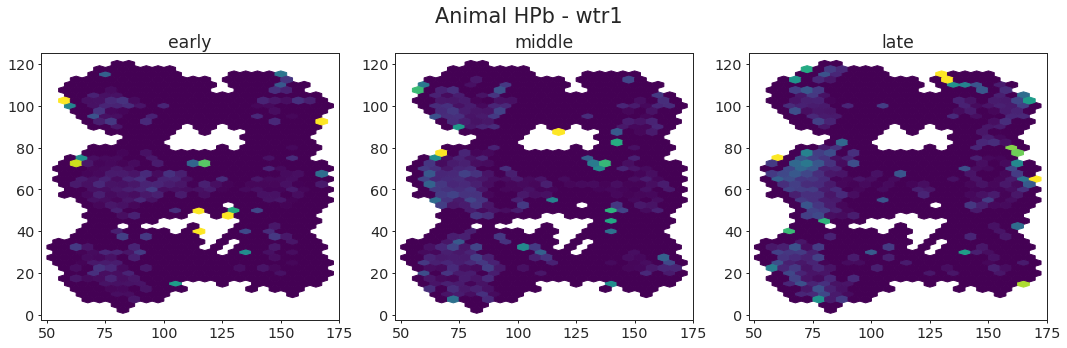

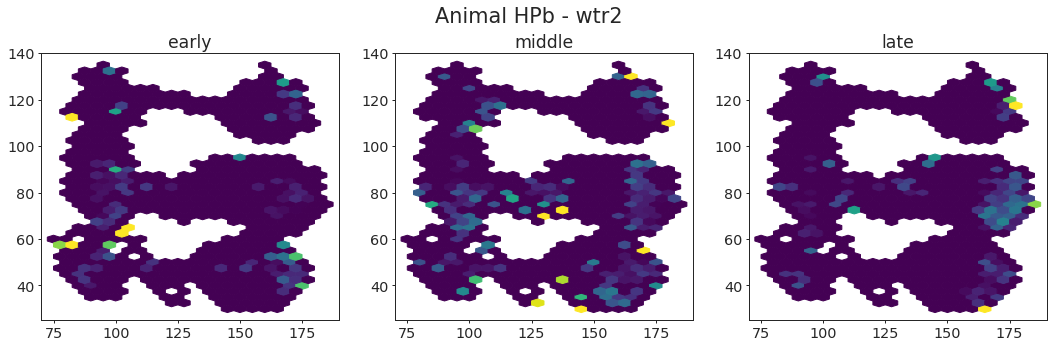

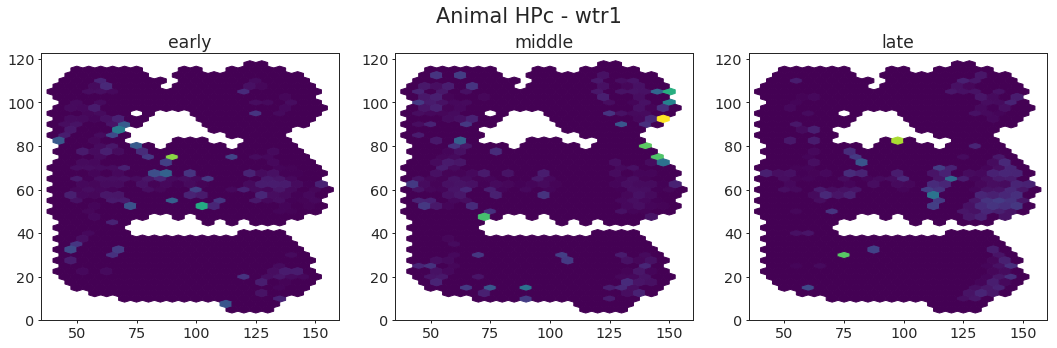

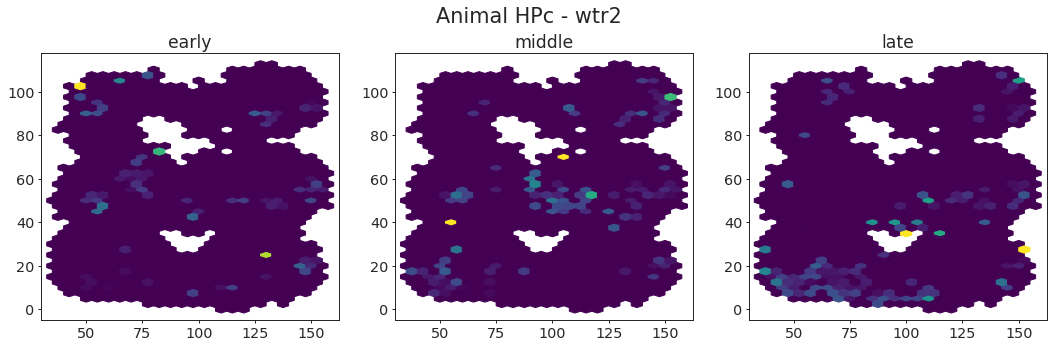

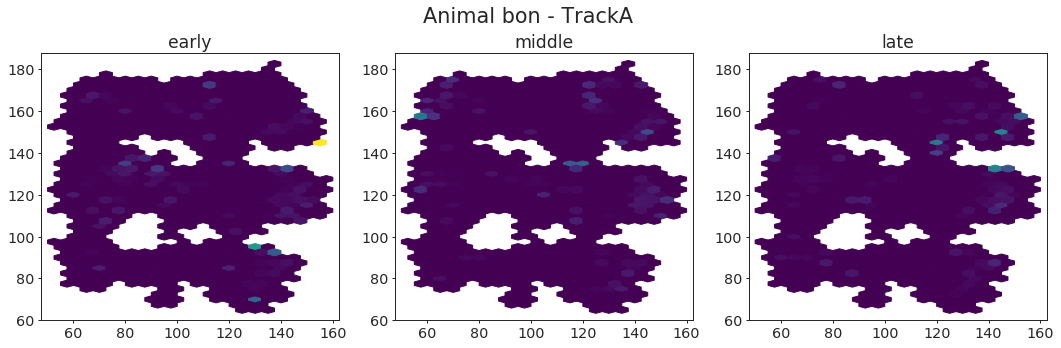

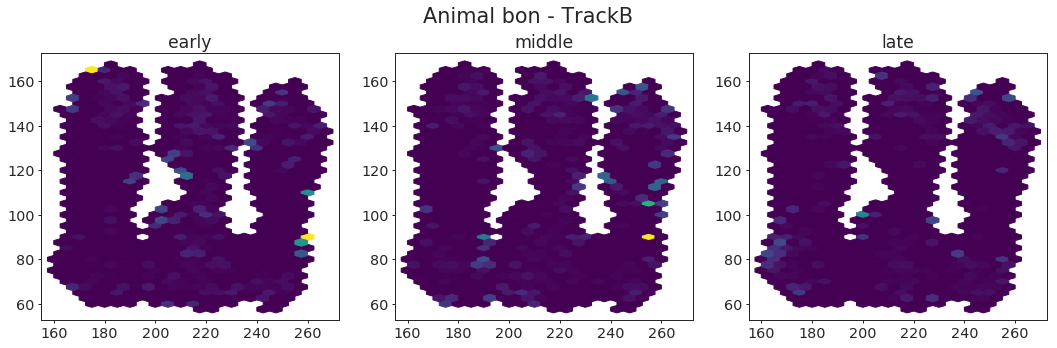

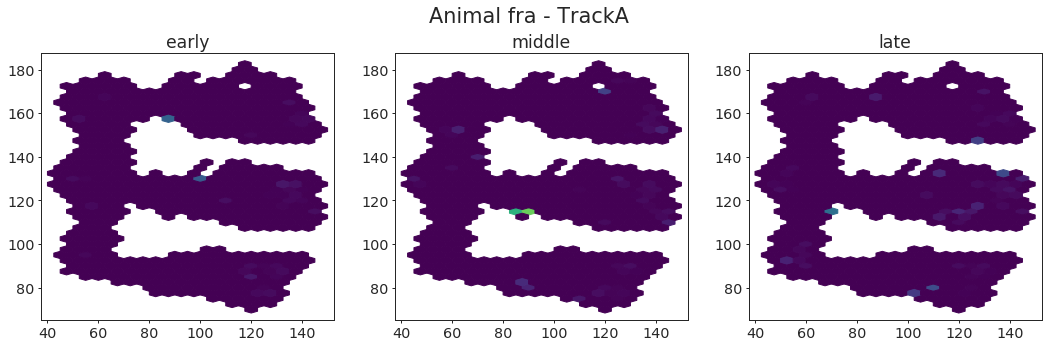

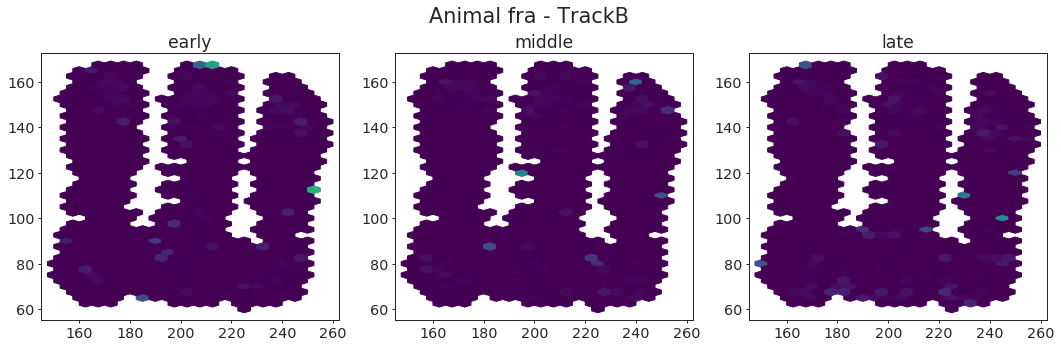

In [35]:
from src.parameters import GRIDSIZE, EXTENT, SAMPLING_FREQUENCY

covariate = 'session_time'
for name, group in replay_info.groupby(['animal', 'environment']):
    grouped = group.groupby(covariate)
    n_levels = len(grouped)
    fig, axes = plt.subplots(1, n_levels, figsize=(5 * n_levels, 5), sharex=True, sharey=True)
    occupancy = po.xs(name[:2]).reset_index().set_index(['center_x', 'center_y']).sort_index()
    for ax, (level, level_group) in zip(axes, grouped):
        event_count = ax.hexbin(level_group.x_position, level_group.y_position,
                                gridsize=GRIDSIZE, extent=EXTENT);
        ax.cla()
        event_count = pd.DataFrame(
                {'event_count': event_count.get_array(),
                 'center_x': event_count.get_offsets()[:, 0],
                 'center_y': event_count.get_offsets()[:, 1]}).set_index(['center_x', 'center_y']).sort_index()
        normalized_count = pd.concat((event_count, occupancy), axis=1).reset_index()
        normalized_count['normalized_count'] = (
            SAMPLING_FREQUENCY * normalized_count.event_count / normalized_count.occupancy_count)
        mappable = ax.hexbin(normalized_count.center_x, normalized_count.center_y,
                             C=normalized_count.normalized_count, gridsize=GRIDSIZE, extent=EXTENT,
                             cmap='viridis', vmin=0, vmax=2)
#         ax.scatter(level_group.x_position, level_group.y_position, color='red', s=2)
        ax.set_title(level)
        xlim = np.percentile(
            normalized_count.center_x[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ylim = np.percentile(
            normalized_count.center_y[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ax.set_xlim(xlim + [-5, 5])
        ax.set_ylim(ylim + [-5, 5])
    fig.suptitle('Animal {0} - {1}'.format(*name))
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

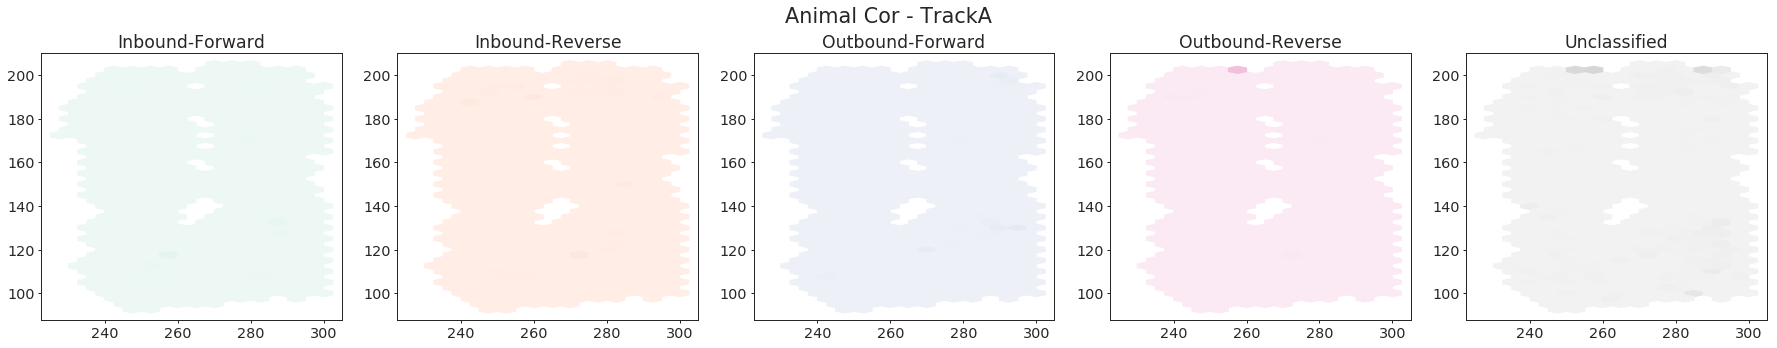

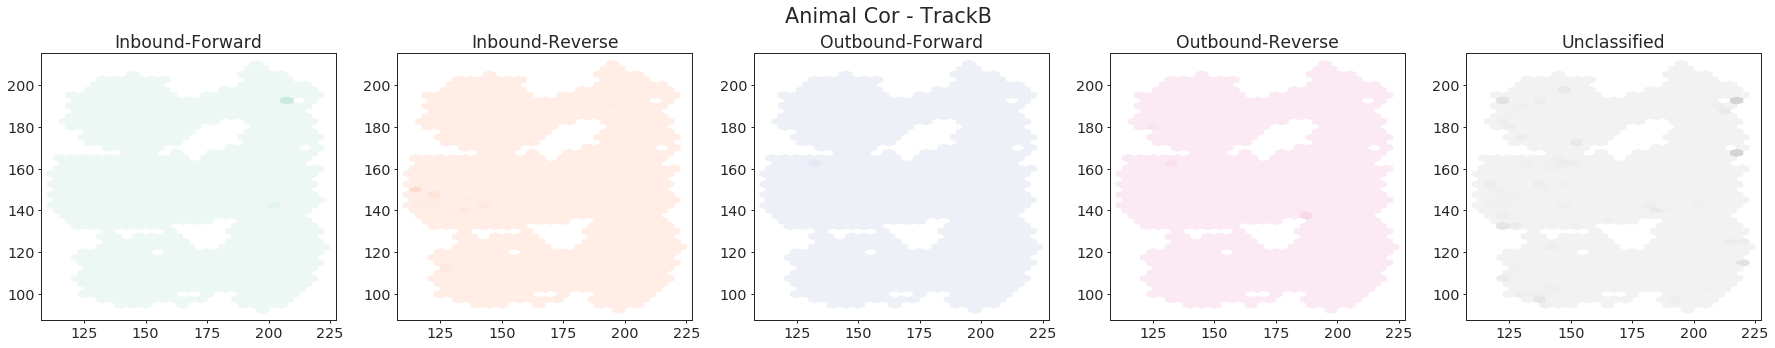

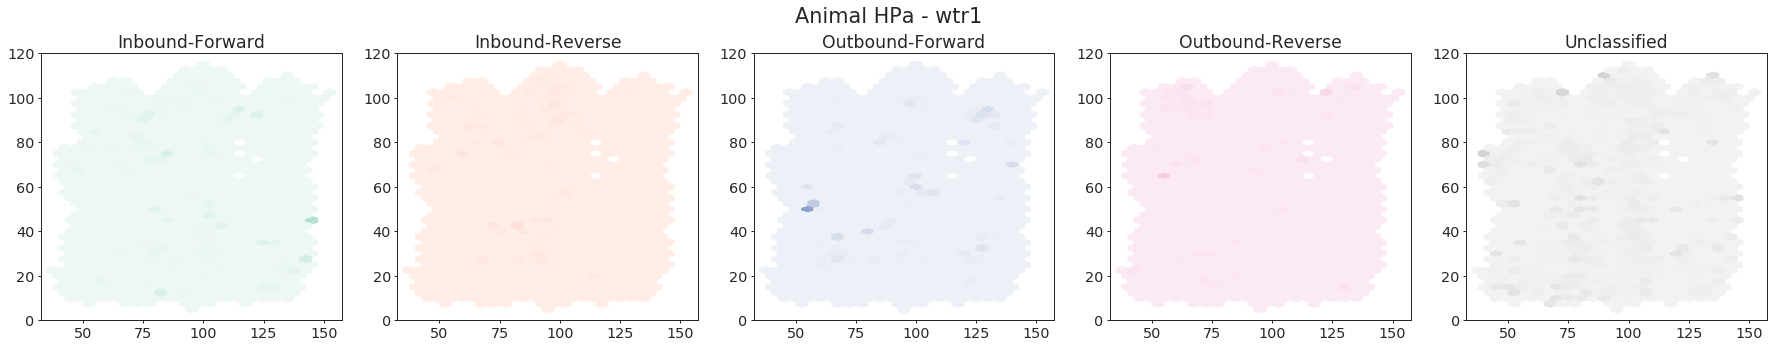

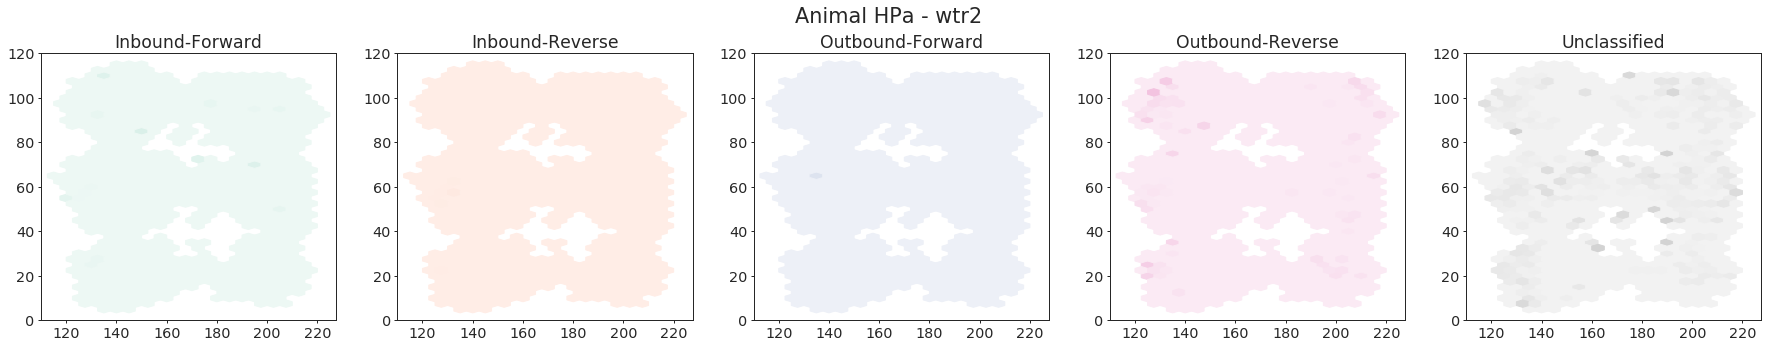

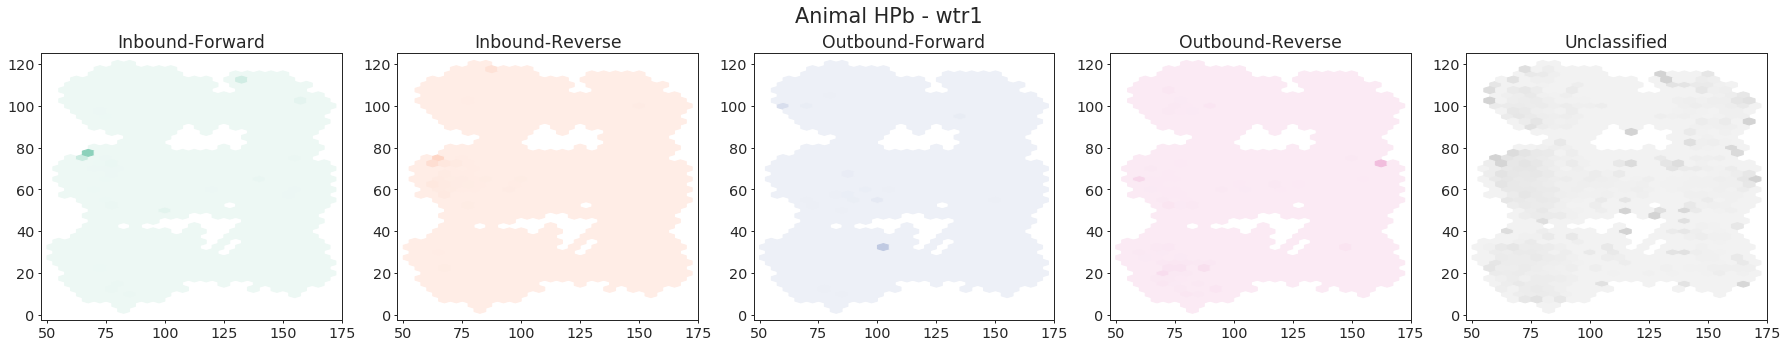

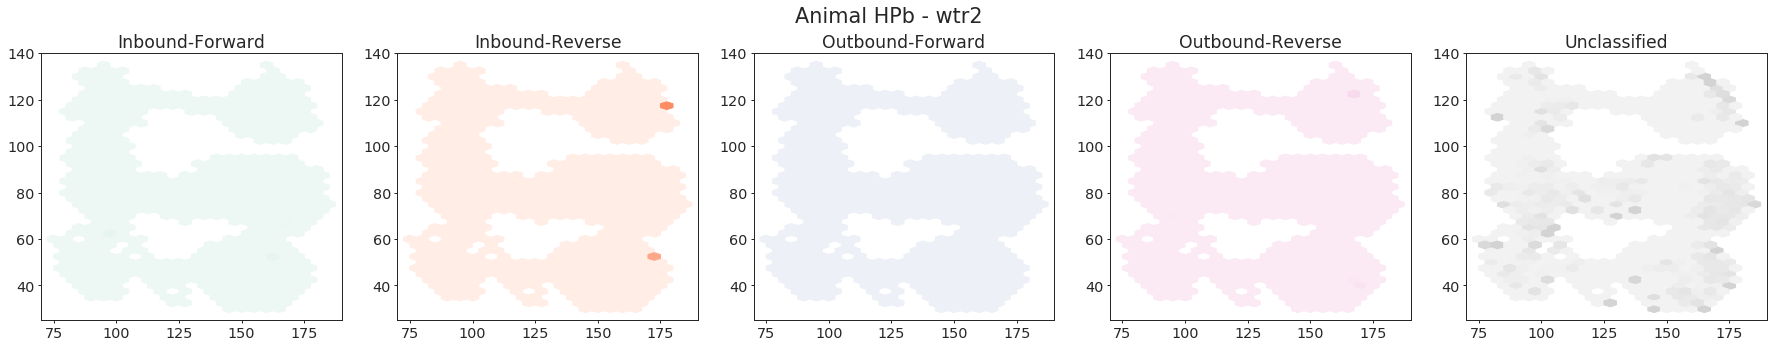

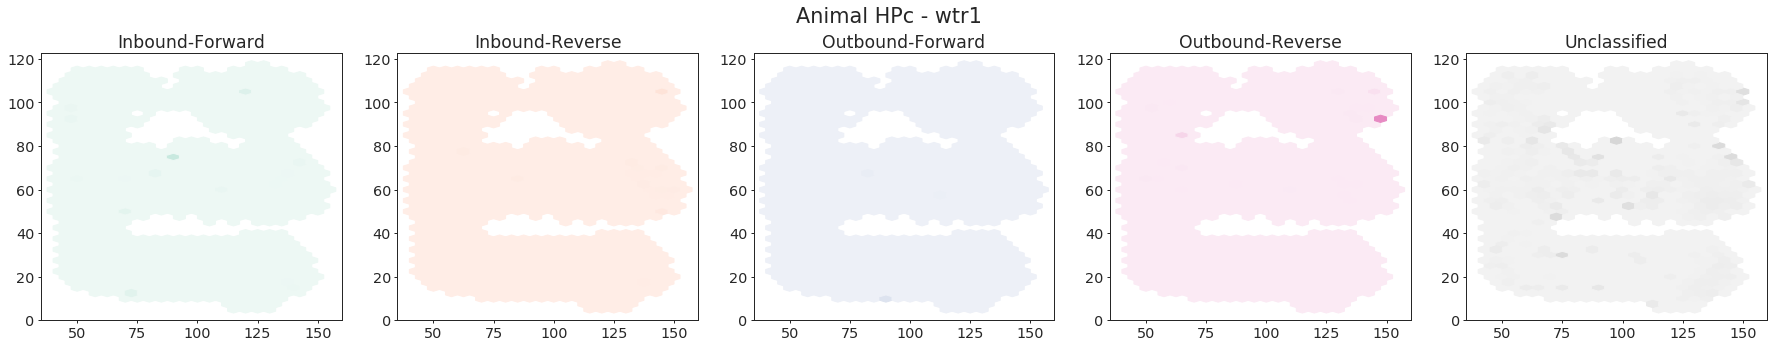

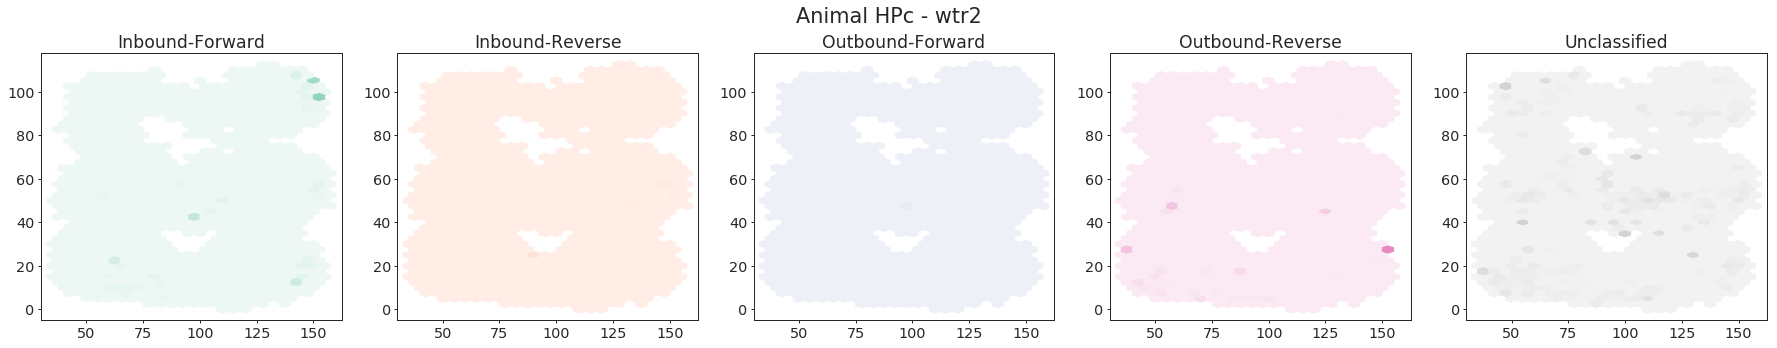

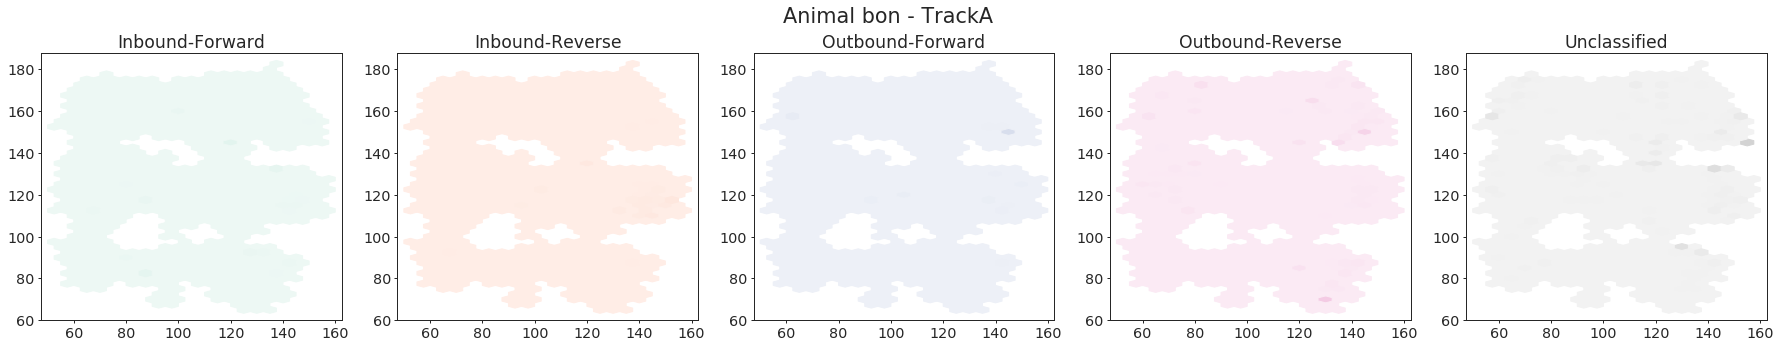

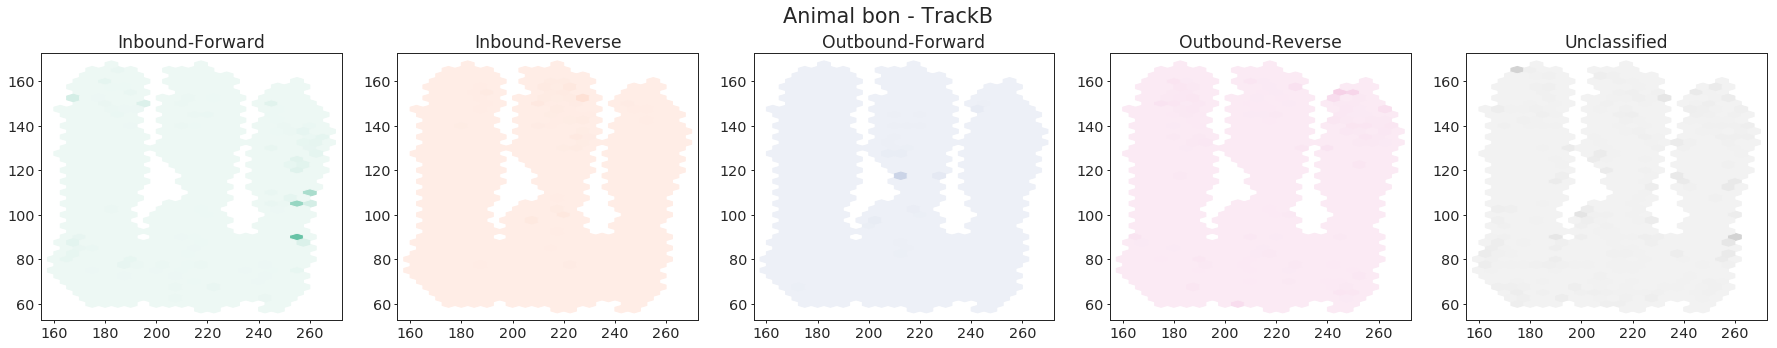

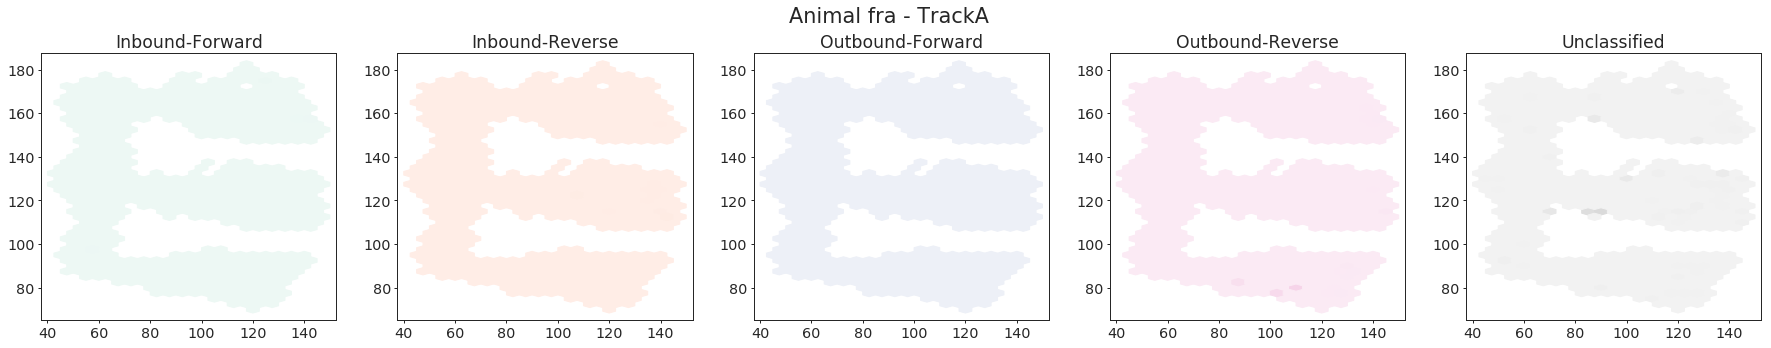

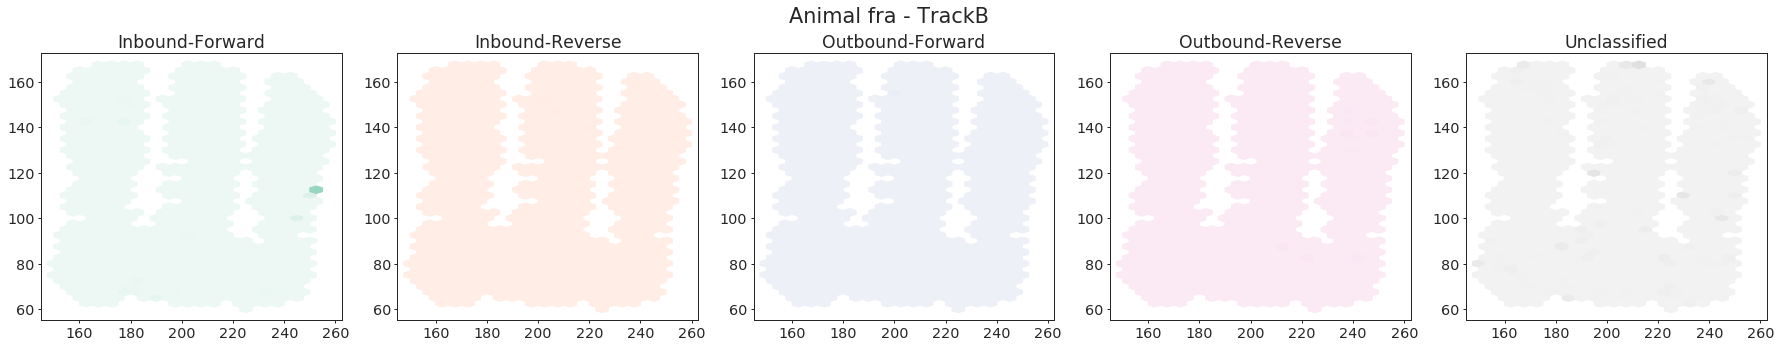

In [36]:
from src.parameters import GRIDSIZE, EXTENT, SAMPLING_FREQUENCY

covariate = 'predicted_state'
for name, group in replay_info.groupby(['animal', 'environment']):
    grouped = group.groupby(covariate)
    n_levels = len(grouped)
    fig, axes = plt.subplots(1, n_levels, figsize=(5 * n_levels, 5), sharex=True, sharey=True)
    occupancy = po.xs(name[:2]).reset_index().set_index(['center_x', 'center_y']).sort_index()
    for ax, (level, level_group) in zip(axes, grouped):
        event_count = ax.hexbin(level_group.x_position, level_group.y_position,
                                gridsize=GRIDSIZE, extent=EXTENT);
        ax.cla()
        event_count = pd.DataFrame(
                {'event_count': event_count.get_array(),
                 'center_x': event_count.get_offsets()[:, 0],
                 'center_y': event_count.get_offsets()[:, 1]}).set_index(['center_x', 'center_y']).sort_index()
        normalized_count = pd.concat((event_count, occupancy), axis=1).reset_index()
        normalized_count['normalized_count'] = (
            SAMPLING_FREQUENCY * normalized_count.event_count / normalized_count.occupancy_count)
        mappable = ax.hexbin(normalized_count.center_x, normalized_count.center_y,
                             C=normalized_count.normalized_count, gridsize=GRIDSIZE, extent=EXTENT,
                             cmap=sns.light_palette(COLORS[level], as_cmap=True), vmin=0, vmax=2)
#         ax.scatter(level_group.x_position, level_group.y_position, color='red', s=2)
        ax.set_title(level)
        xlim = np.percentile(
            normalized_count.center_x[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ylim = np.percentile(
            normalized_count.center_y[~np.isinf(normalized_count.normalized_count) &
                                      ~np.isnan(normalized_count.normalized_count)], [0, 100])
        ax.set_xlim(xlim + [-5, 5])
        ax.set_ylim(ylim + [-5, 5])
    fig.suptitle('Animal {0} - {1}'.format(*name))
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)